In [1]:
from HOX_evolution import *
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import lorenz, logistic_map
import networkx as nx
import copy
import scipy 
import matplotlib.pyplot as plt
#from treelib import Node, Tree
from dask.distributed import Client

print(nx.__version__)
print(scipy.__version__)

2.5
1.6.2


In [2]:
rpy.verbosity(0)

0

In [3]:
def test_genome_as_reservoir(adjacency_matrix, data, prediction_length, train_to, test_to):
    weights = np.random.normal(0,1, size = adjacency_matrix.shape)
    weights = weights / (weights*adjacency_matrix.shape[0])

    weights *= adjacency_matrix

    reservoir = Reservoir(W = weights)
    readout = Ridge(ridge = 1e-7)
    model = reservoir >> readout 


    training_data_input = data[:train_to]
    training_data_desired_output = data[prediction_length:train_to + prediction_length, : ]

    test_data_input = data[train_to:test_to]
    test_data_desired_output = data[train_to + prediction_length: test_to + prediction_length,:]

    model.fit(training_data_input, training_data_desired_output)

    prediction = model.run(test_data_input)

    performance = np.linalg.norm(prediction - test_data_desired_output, ord = 2)

    return performance, prediction, test_data_desired_output




In [4]:
internal_weights = np.ones((3,3))
input_weights = np.ones((3))
input_weights = input_weights[:,np.newaxis]
data = np.ones((10))
data = data[:,np.newaxis]

reservoir = Reservoir(W = internal_weights, Win = input_weights)
reservoir.run(data)


array([[0.76159416, 0.76159416, 0.76159416],
       [0.99719911, 0.99719911, 0.99719911],
       [0.99931794, 0.99931794, 0.99931794],
       [0.99932655, 0.99932655, 0.99932655],
       [0.99932659, 0.99932659, 0.99932659],
       [0.99932659, 0.99932659, 0.99932659],
       [0.99932659, 0.99932659, 0.99932659],
       [0.99932659, 0.99932659, 0.99932659],
       [0.99932659, 0.99932659, 0.99932659],
       [0.99932659, 0.99932659, 0.99932659]])

In [5]:
print(reservoir.Win)

[[1.]
 [1.]
 [1.]]


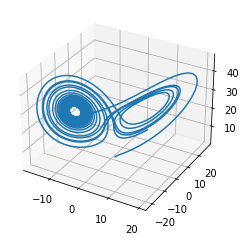

In [6]:
data = lorenz(2000, h = 0.01)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data[:,0], data[:,1], data[:,2])

# Reserach note 1
Setting the evolution to target large prediction steps seems to lead to a too flat landscape because the networks fail their predictions. I'll try a seascape type approach instead by moving the prediction step depending on the networks performance going above a treshold

In [ ]:


#data = logistic_map(2000)
data = lorenz(2000, h = 0.01)

#data  = data[:,np.newaxis]
data = 2 * (data - data.min()) / (data.max() - data.min()) - 1

train_to = 1000
prediction_lengths = np.arange(1,300)
test_to = 1500

goalpoast_treshold = 0.1
goalpoast = 0

initial_genome = [[0,1,0.1],[1,2,0.2],[2,3, 0.3],[3,4, 0.4],[4,2, 0.5],[4,5, 0.6],[5,6, 0.7]]



population_size = 64
genome_population = [copy.deepcopy(initial_genome) for i in range(population_size)]

n_generations = 10000

generation_scores = []

for generation in range(n_generations):
    prediction_length = prediction_lengths[goalpoast]
    print("GENERATION: ", generation)
    mutated_generation = []

    for genome in genome_population:
        mutated_genome = copy.deepcopy(genome)
        for i in range(1):
            mutated_genome = mutate_genome_with_hox(mutated_genome)
        mutated_generation.append(mutated_genome)

    small_worldness_scores = []
    graph_sizes = []
    genome_depths = []
    predictions = []

    for mutated_genome in mutated_generation:
        connectivity_matrix = transcribe_hierarchical_genome(mutated_genome)
        #plt.imshow(connectivity_matrix)
        #plt.show()
        graph = nx.from_numpy_matrix(connectivity_matrix)

        largest_subgraph = sorted(nx.connected_components(graph), key = len, reverse = True)
        largest_subgraph = graph.subgraph(largest_subgraph[0])

        graph_sizes.append(largest_subgraph.number_of_nodes())
        genome_depths.append(compute_genome_depth(mutated_genome))
        adjacency_matrix = nx.adjacency_matrix(largest_subgraph)
        #adjacency_matrix = nx.to_numpy_array(adjacency_matrix)

        future_omega, y_hat, y = test_genome_as_reservoir(adjacency_matrix, data, prediction_length, train_to, test_to)

        predictions.append([y_hat, y])
        small_worldness_scores.append(future_omega)

    #small_worldness_scores = client.gather(small_worldness_scores)

    k = 0
    for i, small_worldness_score in enumerate(small_worldness_scores):
        abs_omega = np.abs(small_worldness_score + (1 - 1/graph_sizes[i])) #no abs for lattice
        #small_worldness_scores[i] = abs_omega  + 5/(graph_sizes[i])
        print(k, " omega ", abs_omega, " genome depth: ", genome_depths[i], "Size: ", graph_sizes[i])
        print("    Fitness: ", small_worldness_scores[i])
        k+=1


    small_worldness_scores = np.array(small_worldness_scores)
    #small_worldness_scores = np.abs(small_worldness_scores)
    #print("Scores ", small_worldness_scores)
    small_worldness_scores[small_worldness_scores == -np.inf] = 10

    generation_scores.append(copy.deepcopy(small_worldness_scores))
    genome_population = []

    goalpoast_moved = False
    for ranking, i in enumerate([14,10,8,7,6,5,4,3,2,1,1,1,1]):

        best_index = np.nanargmin(small_worldness_scores)
        best = small_worldness_scores[best_index]

        if best < goalpoast_treshold and goalpoast < len(prediction_lengths) and goalpoast_moved == False:
            goalpoast += 1
            goalpoast_moved = True


        print("Organism index: ", best_index, "Fitness: ", best)
        if ranking == 0:
            connectivity_matrix = transcribe_hierarchical_genome(mutated_generation[best_index])
            connectivity_matrix = connectivity_matrix != 0
            graph = nx.from_numpy_matrix(connectivity_matrix)
            largest_subgraph = sorted(nx.connected_components(graph), key = len, reverse = True)
            largest_subgraph = graph.subgraph(largest_subgraph[0])
            
            fig = plt.figure(figsize = (40,20))
            ax = fig.add_subplot(1, 2, 1)
            nx.draw_kamada_kawai(largest_subgraph, node_size = 20)
            ax = fig.add_subplot(1, 2, 2, projection='3d')
            y_hat = predictions[best_index][0]
            y = predictions[best_index][1]
            ax.plot(y_hat[:,0], y_hat[:,1], y_hat[:,2])
            ax.plot(y[:,0], y[:,1], y[:,2])
            fig.savefig("Generation_" + str(generation) +" PredictionLength_ " + str(prediction_length) + " Ranking_" + str(ranking) + " Fitness_" + str(best) + ".jpg")
            #draw_tree(mutated_generation[best_index])
            plt.close("all")
        genome_population.extend([copy.deepcopy(mutated_generation[best_index]) for k in range(i)])

        small_worldness_scores[best_index] = 1000

GENERATION:  0
Mutate Connection
Hox copy
Hox group
Mutate Connection
Add connection
Hox copy
 Hox Shuffle
[2, 3, 0.3]
Hox remove
Add Node
Mutated Weight
 Hox Shuffle
[0, 1, 0.1]
Add connection
Mutated Weight
Hox copy
Mutate Connection
 Hox Shuffle
[0, 1, 0.1]
Add connection
Add connection
Hox group
Mutate Connection
Hox group
Hox group
Hox group
Hox copy
Hox group
Hox copy
Mutated Weight
 Hox Shuffle
[4, 2, 0.5]
Mutated Weight
Add connection
Mutated Weight
Hox group
Hox remove
Add connection
Hox copy
 Hox Shuffle
[5, 6, 0.7]
Hox copy
Hox group
Hox group
Hox remove
 Hox Shuffle
[5, 6, 0.7]
Add Node
Add Node
Mutated Weight
Hox group
 Hox Shuffle
[1, 2, 0.2]
Hox copy
Hox remove
Mutated Weight
Hox remove
Mutated Weight
Add Node
Remove Node
Mutated Weight
Hox remove
Add Node
Mutated Weight
Mutate Connection
Mutate Connection
Mutated Weight
Hox copy
Hox remove
Hox remove
Hox group
0  omega  6.659138315899435  genome depth:  2 Size:  5
    Fitness:  5.859138315899435
1  omega  1.618701103128

Organism index:  41 Fitness:  0.433697264004526
Organism index:  19 Fitness:  0.5633522120144647
Organism index:  11 Fitness:  0.6032449581291007
Organism index:  8 Fitness:  0.6553456513132941
Organism index:  49 Fitness:  0.672591176419045
Organism index:  1 Fitness:  0.7362038950874777
Organism index:  13 Fitness:  0.9882528752750245
Organism index:  44 Fitness:  1.2515502508835536
Organism index:  7 Fitness:  1.2685494843946712
Organism index:  27 Fitness:  1.443986837270264
Organism index:  59 Fitness:  1.5407489219066381
Organism index:  12 Fitness:  1.5835004933070131
GENERATION:  2
Remove Node
Hox copy
 Hox Shuffle
[0, 1, 0.1]
Mutate Connection
Mutate Connection
Mutate Connection
Mutate Connection
Hox group
Mutated Weight
Mutated Weight
Add connection
 Hox Shuffle
[2, 3, 0.3]
Mutated Weight
 Hox Shuffle
[1, 7, -0.07829823070763245]
Remove Node
Add connection
Mutated Weight
Mutate Connection
Hox copy
Mutate Connection
Remove Node
Remove Node
 Hox Shuffle
[5, 6, 0.7]
 Hox Shuffle

0  omega  2.889583732599659  genome depth:  5 Size:  28
    Fitness:  1.9252980183139448
1  omega  1.2665200052266887  genome depth:  5 Size:  28
    Fitness:  0.3022342909409745
2  omega  1.3100567436493904  genome depth:  5 Size:  28
    Fitness:  0.34577102936367604
3  omega  1.7394691253024799  genome depth:  5 Size:  29
    Fitness:  0.7739518839231695
4  omega  1.396433230036696  genome depth:  5 Size:  28
    Fitness:  0.4321475157509816
5  omega  1.6717753406882432  genome depth:  5 Size:  21
    Fitness:  0.7193943883072907
6  omega  1.4510249667299884  genome depth:  6 Size:  56
    Fitness:  0.46888210958713117
7  omega  1.3806951220954928  genome depth:  6 Size:  56
    Fitness:  0.3985522649526358
8  omega  1.6070520262526684  genome depth:  6 Size:  28
    Fitness:  0.6427663119669542
9  omega  1.8839023840878641  genome depth:  5 Size:  28
    Fitness:  0.9196166698021498
10  omega  1.223343441715079  genome depth:  5 Size:  28
    Fitness:  0.25905772742936467
11  omega

0  omega  1.1124864085292832  genome depth:  6 Size:  112
    Fitness:  0.12141497995785452
1  omega  1.2740037905507304  genome depth:  5 Size:  42
    Fitness:  0.29781331436025427
2  omega  1.3659678136996858  genome depth:  5 Size:  56
    Fitness:  0.38382495655682874
3  omega  1.2737379160962155  genome depth:  5 Size:  56
    Fitness:  0.2915950589533584
4  omega  1.1059874006796473  genome depth:  5 Size:  56
    Fitness:  0.12384454353679025
5  omega  1.2486068206338024  genome depth:  5 Size:  56
    Fitness:  0.26646396349094514
6  omega  1.3308804440814512  genome depth:  5 Size:  56
    Fitness:  0.34873758693859414
7  omega  1.4168734421108133  genome depth:  5 Size:  54
    Fitness:  0.43539196062933183
8  omega  1.3176986506677997  genome depth:  5 Size:  56
    Fitness:  0.33555579352494247
9  omega  1.2130767937745128  genome depth:  7 Size:  112
    Fitness:  0.22200536520308425
10  omega  1.2679824368033756  genome depth:  5 Size:  56
    Fitness:  0.285839579660518

Organism index:  58 Fitness:  0.1556441433486283
Organism index:  33 Fitness:  0.16801361355365232
Organism index:  8 Fitness:  0.17274114799793958
Organism index:  35 Fitness:  0.17482775836565864
Organism index:  28 Fitness:  0.17794397735706127
Organism index:  23 Fitness:  0.18127048138653412
Organism index:  10 Fitness:  0.20079360028632254
Organism index:  41 Fitness:  0.20185241867618456
Organism index:  12 Fitness:  0.2083321758360478
Organism index:  22 Fitness:  0.2274537348254745
Organism index:  11 Fitness:  0.22886656836750696
Organism index:  32 Fitness:  0.23188499122237266
GENERATION:  6
Mutated Weight
Mutated Weight
Mutate Connection
Mutated Weight
Add connection
Mutate Connection
Mutated Weight
Mutated Weight
Mutated Weight
Add connection
 Hox Shuffle
[[14, 15, 0.1], [15, 16, 0.2], [16, 17, 0.3], [17, 18, 0.4], [18, 16, 0.5], [18, 19, 0.6], [19, 20, 0.7], [[21, 22, 0.1], [22, 23, 0.2], [23, 24, 0.3], [24, 25, 0.4], [25, 23, 0.5], [25, 26, 0.6], [26, 27, 0.7]], [16, 25

Add connection
Mutated Weight
Mutated Weight
Add Node
Remove Node
Hox copy
Mutated Weight
Hox remove
Add connection
Hox remove
Remove Node
Mutate Connection
Mutated Weight
Hox remove
Hox group
Hox remove
Add connection
Mutated Weight
Add connection
Hox copy
Mutated Weight
Hox group
 Hox Shuffle
[[56, 57, 0.1], [57, 58, 0.2], [58, 59, 0.3], [95, 60, 0.4], [60, 58, 0.5], [60, 61, 0.6], [61, 62, 0.7], [[63, 64, 0.1], [64, 65, 0.2], [65, 66, 0.3], [66, 67, 0.4], [67, 65, 0.5], [67, 68, 0.6], [68, 69, 0.7]], [58, 67, 0.05335995176577876], [[70, 71, 0.1], [71, 72, 0.2], [72, 73, 0.3], [73, 74, 0.4], [74, 72, 0.5], [74, 75, 0.6], [75, 76, 0.7], [[77, 78, 0.1], [78, 79, 0.2], [79, 80, 0.3], [80, 81, 0.4], [81, 79, 0.5], [81, 82, 0.6], [82, 83, 0.7]], [72, 81, 0.05335995176577876]], [60, 74, 0.029440478179539403], [[84, 85, 0.1], [85, 86, 0.2], [86, 87, 0.3], [87, 88, 0.4], [88, 86, 0.5], [88, 89, 0.6], [89, 90, 0.7], [[91, 92, 0.1], [92, 93, 0.2], [93, 94, 0.3], [94, 95, 0.4], [95, 93, 0.5], [

Hox copy
Hox group
Remove Node
 Hox Shuffle
[1, 2, 0.3]
Hox remove
Mutate Connection
Hox copy
Add Node
Mutate Connection
 Hox Shuffle
[4, 5, 0.6]
Hox group
Mutated Weight
Mutated Weight
Add connection
Mutated Weight
Mutated Weight
Hox group
Hox copy
 Hox Shuffle
[[7, 8, 0.1], [8, 9, 0.2], [9, 10, 0.3], [10, 11, 0.4], [11, 9, 0.35959309286376495], [11, 12, 0.6], [12, 13, 0.7]]
Mutated Weight
Hox remove
 Hox Shuffle
[3, 4, 0.6]
0  omega  1.790277344307398  genome depth:  8 Size:  224
    Fitness:  0.7947416300216837
1  omega  1.2579920082110974  genome depth:  8 Size:  224
    Fitness:  0.262456293925383
2  omega  1.3290429512277968  genome depth:  8 Size:  224
    Fitness:  0.33350723694208256
3  omega  1.2802215750337265  genome depth:  8 Size:  224
    Fitness:  0.2846858607480123
4  omega  1.2857169171336986  genome depth:  8 Size:  216
    Fitness:  0.29034654676332833
5  omega  1.5563061674747865  genome depth:  8 Size:  224
    Fitness:  0.5607704531890721
6  omega  1.475505776172

Mutate Connection
Add connection
Remove Node
 Hox Shuffle
[[7, 8, 0.1], [8, 9, 0.2], [9, 10, 0.3], [10, 11, 0.4], [11, 9, 0.5], [11, 12, 0.6], [12, 13, 0.7]]
Add Node
Mutated Weight
Add connection
Mutate Connection
Remove Node
 Hox Shuffle
[60, 74, 0.029440478179539403]
Mutate Connection
Mutated Weight
Hox copy
Mutate Connection
 Hox Shuffle
[7, 21, -0.044425516953330614]
Add connection
Mutate Connection
Mutate Connection
Add Node
Mutate Connection
Mutate Connection
Hox remove
Hox remove
Hox group
Mutate Connection
Mutate Connection
Mutate Connection
Remove Node
Hox remove
Add Node
Hox copy
Hox remove
Mutate Connection
Add Node
0  omega  1.1563957989788793  genome depth:  10 Size:  444
    Fitness:  0.1586480512311316
1  omega  1.2347127918004819  genome depth:  10 Size:  447
    Fitness:  0.23694992826580633
2  omega  1.173231389861178  genome depth:  10 Size:  251
    Fitness:  0.17721545360619775
3  omega  1.1499486502695975  genome depth:  10 Size:  444
    Fitness:  0.152200902521

Mutate Connection
Mutate Connection
Add connection
Mutate Connection
Mutate Connection
Mutate Connection
Mutated Weight
 Hox Shuffle
[[111, 112, 0.1], [112, 113, 0.2], [113, 114, 0.3], [114, 115, 0.4], [115, 113, 0.35959309286376495], [115, 116, 0.6], [116, 117, 0.7], [[118, 119, 0.1], [119, 120, 0.2], [120, 121, 0.3], [121, 122, 0.4], [122, 120, 0.35959309286376495], [122, 123, 0.6], [123, 124, 0.7]], [113, 120, -0.0951793419028148], [[125, 126, 0.1], [126, 127, 0.2], [127, 128, 0.3], [128, 129, 0.4], [129, 127, 0.35959309286376495], [129, 130, 0.6], [130, 131, 0.7], [[132, 133, 0.1], [133, 134, 0.2], [134, 135, 0.3], [135, 136, 0.4], [136, 134, 0.35959309286376495], [136, 137, 0.6], [137, 138, 0.7]], [127, 134, -0.0951793419028148]], [119, 133, -0.044425516953330614], [[139, 140, 0.1], [140, 141, 0.2], [141, 142, 0.3], [142, 143, 0.4], [143, 141, 0.35959309286376495], [143, 144, 0.6], [144, 145, 0.7], [[146, 147, 0.1], [147, 148, 0.2], [148, 149, 0.3], [149, 150, 0.4], [150, 148, 0.3

Organism index:  45 Fitness:  0.10526137173776191
Organism index:  28 Fitness:  0.11140769116407062
Organism index:  35 Fitness:  0.11537540966210771
Organism index:  3 Fitness:  0.12120677345354386
Organism index:  2 Fitness:  0.13351673462300406
Organism index:  10 Fitness:  0.13518200248646087
Organism index:  9 Fitness:  0.13534494741089456
Organism index:  12 Fitness:  0.13608616702112497
Organism index:  25 Fitness:  0.14323329865831172
Organism index:  32 Fitness:  0.1455656201800345
Organism index:  27 Fitness:  0.14739511606350217
Organism index:  41 Fitness:  0.15127075014978703
GENERATION:  11
Hox group
Mutated Weight
Add connection
Hox group
Mutated Weight
Mutate Connection
 Hox Shuffle
[0, 1, 0.2]
Add Node
Add connection
 Hox Shuffle
[122, 679, -0.03252357936474036]
Add connection
Mutate Connection
Remove Node
Mutated Weight
Mutated Weight
 Hox Shuffle
[3, 4, 0.6]
Add Node
Hox group
Remove Node
Hox group
Hox copy
Hox group
Add Node
Mutated Weight
Hox group
Hox copy
Mutated

Organism index:  9 Fitness:  0.13292664445200325
Organism index:  49 Fitness:  0.13325385242598206
Organism index:  6 Fitness:  0.13743389331029404
Organism index:  14 Fitness:  0.1439106413588542
Organism index:  29 Fitness:  0.14809279814446816
Organism index:  43 Fitness:  0.16217346367536875
Organism index:  11 Fitness:  0.16225328696237518
Organism index:  56 Fitness:  0.16752971978001013
Organism index:  19 Fitness:  0.16979588992988343
Organism index:  44 Fitness:  0.17213970774493176
Organism index:  47 Fitness:  0.1765100589692095
Organism index:  27 Fitness:  0.1876271823935292
GENERATION:  12
Hox remove
Mutate Connection
Add Node
Add Node
Mutated Weight
Mutated Weight
Add connection
 Hox Shuffle
[[13, 14, 0.1], [14, 15, 0.2], [130, 16, 0.3], [16, 17, 0.4], [17, 15, 0.35959309286376495], [17, 18, 0.6], [18, 19, 0.7], [[20, 21, 0.1], [21, 22, 0.2], [22, 23, 0.3], [23, 24, 0.4], [24, 22, 0.35959309286376495], [24, 25, 0.6], [25, 26, 0.7]], [15, 22, -0.0951793419028148]]
Add con

Mutate Connection
Mutate Connection
Hox group
Mutate Connection
Hox remove
Hox group
Mutated Weight
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
Hox remove
Mutated Weight
Mutate Connection
Hox group
 Hox Shuffle
[7, 21, -0.044425516953330614]
Mutate Connection
Add connection
 Hox Shuffle
[7, 21, -0.044425516953330614]
Mutated Weight
Hox group
Add connection
Add Node
Mutated Weight
Mutated Weight
Hox remove
Add connection
 Hox Shuffle
[9, 10, 0.4]
Mutated Weight
Mutated Weight
Hox group
Mutated Weight
Mutate Connection
Hox group
Mutated Weight
Mutate Connection
Hox group
Hox remove
Mutated Weight
Hox remove
Hox copy
Mutate Connection
Mutated Weight
Hox remove
 Hox Shuffle
[17, 38, -0.08583793494392791]
Mutate Connection
Hox copy
Hox copy
Mutated Weight
Add connection
Mutate Connection
Mutate Connection
Mutate Connection
Mutate Connection
 Hox Shuffle
[4, 5, 0.7]
Mutate Connection
Mutate Connection
Mutated Weight
 Hox Shuffle
[2, 3, 0.4]
0  omega  1.2200307850632337  genom

 Hox Shuffle
[3, 4, 0.6]
 Hox Shuffle
[7, 21, -0.044425516953330614]
Mutated Weight
Mutate Connection
Add connection
Mutated Weight
Add connection
 Hox Shuffle
[122, 679, -0.03252357936474036]
 Hox Shuffle
[[[6, 7, 0.1], [7, 8, 0.2], [8, 9, 0.3], [9, 10, 0.4], [10, 8, 0.35959309286376495], [10, 11, 0.6], [11, 12, 0.7]], [0, 1, 0.2]]
Mutated Weight
Remove Node
Add connection
 Hox Shuffle
[[13, 14, 0.1], [14, 15, 0.2], [130, 16, 0.3], [16, 17, 0.4], [17, 15, 0.35959309286376495], [17, 18, 0.6], [18, 19, 0.7], [[20, 21, 0.1], [21, 22, 0.2], [22, 23, 0.3], [23, 24, 0.4], [24, 22, 0.35959309286376495], [24, 25, 0.6], [25, 26, 0.7]], [15, 22, -0.0951793419028148]]
Mutate Connection
Remove Node
Remove Node
Hox group
Hox group
Hox remove
Add connection
Hox remove
Hox remove
Mutate Connection
Mutated Weight
Mutated Weight
Add connection
Mutated Weight
Mutated Weight
Mutated Weight
Add connection
Mutated Weight
Hox group
Mutate Connection
Mutated Weight
Hox group
Mutate Connection
Mutated Weight

Organism index:  4 Fitness:  0.1184908660303678
Organism index:  37 Fitness:  0.12132402214068531
Organism index:  29 Fitness:  0.12298671924954215
Organism index:  35 Fitness:  0.13303956998741034
Organism index:  50 Fitness:  0.13835209324517994
Organism index:  61 Fitness:  0.14345881648927444
Organism index:  39 Fitness:  0.14879163502122272
Organism index:  30 Fitness:  0.15012702532804761
Organism index:  53 Fitness:  0.15017628100572403
Organism index:  41 Fitness:  0.15850735651976564
Organism index:  58 Fitness:  0.16082111502075958
Organism index:  11 Fitness:  0.1672904119925553
GENERATION:  15
Mutate Connection
Mutate Connection
 Hox Shuffle
[3, 100, -0.010301905715133411]
Hox remove
Add connection
Mutated Weight
 Hox Shuffle
[0, 1, 0.2]
Hox copy
Add connection
 Hox Shuffle
[13, 14, 0.1]
Hox group
Mutate Connection
Mutated Weight
Remove Node
Add connection
Add Node
Mutated Weight
Mutate Connection
Remove Node
Mutated Weight
Mutate Connection
 Hox Shuffle
[2, 3, 0.4]
Hox gro

Remove Node
Add connection
Add connection
Mutate Connection
Mutate Connection
Hox remove
Mutated Weight
Mutate Connection
Add Node
Hox remove
Mutated Weight
Mutated Weight
Mutated Weight
Hox group
Mutated Weight
Mutated Weight
Hox group
Add connection
Hox group
Mutated Weight
Mutated Weight
Mutate Connection
Hox group
 Hox Shuffle
[4, 5, 0.7]
 Hox Shuffle
[3, 1, 0.35959309286376495]
Add Node
Add connection
Add Node
Add Node
Mutated Weight
Add connection
Hox group
 Hox Shuffle
[3, 1, 0.35959309286376495]
Hox copy
Add Node
Mutated Weight
Hox group
Mutate Connection
Hox copy
Hox group
Mutated Weight
Add connection
Mutate Connection
Add Node
Hox remove
Hox copy
Mutated Weight
Mutated Weight
Mutated Weight
Mutated Weight
Remove Node
Mutate Connection
Hox remove
Mutated Weight
 Hox Shuffle
[4, 5, 0.7]
Mutated Weight
Hox group
 Hox Shuffle
[30, 31, 0.4]
Hox copy
0  omega  1.76647250337545  genome depth:  12 Size:  895
    Fitness:  0.7675898218112044
1  omega  1.149081421084721  genome depth:

Mutated Weight
Hox remove
Mutate Connection
Mutate Connection
Mutated Weight
Mutate Connection
Mutated Weight
Mutated Weight
Hox remove
0  omega  1.3597310059251728  genome depth:  12 Size:  894
    Fitness:  0.3608495741578349
1  omega  1.2249244452584032  genome depth:  13 Size:  1788
    Fitness:  0.22548372937473415
2  omega  1.2733031194720181  genome depth:  12 Size:  894
    Fitness:  0.27442168770468034
3  omega  1.2434684270679561  genome depth:  12 Size:  894
    Fitness:  0.2445869953006183
4  omega  1.169136695594509  genome depth:  12 Size:  894
    Fitness:  0.17025526382717135
5  omega  1.159528254057561  genome depth:  12 Size:  894
    Fitness:  0.16064682229022323
6  omega  1.2539442771418599  genome depth:  13 Size:  1788
    Fitness:  0.254503561258191
7  omega  1.2916308164335952  genome depth:  12 Size:  894
    Fitness:  0.2927493846662574
8  omega  1.2727920033183517  genome depth:  12 Size:  894
    Fitness:  0.2739105715510139
9  omega  1.1529582525543307  gen

Organism index:  34 Fitness:  0.13068747217041116
Organism index:  46 Fitness:  0.1330446790804875
Organism index:  21 Fitness:  0.13689869122188578
Organism index:  53 Fitness:  0.13952291584721466
Organism index:  48 Fitness:  0.14034650010236382
Organism index:  61 Fitness:  0.14186295241430993
Organism index:  9 Fitness:  0.147312940763574
Organism index:  36 Fitness:  0.148510071852313
Organism index:  50 Fitness:  0.15026119975904656
Organism index:  23 Fitness:  0.1506832722077785
Organism index:  59 Fitness:  0.15400546741786877
Organism index:  44 Fitness:  0.16144197572077087
GENERATION:  19
Mutate Connection
Hox remove
Add Node
Mutate Connection
Mutate Connection
Mutated Weight
Mutate Connection
Mutate Connection
Hox remove
Mutated Weight
Mutate Connection
Hox remove
Hox remove
Mutate Connection
Mutated Weight
Mutate Connection
Mutate Connection
Mutate Connection
Hox group
Hox remove
 Hox Shuffle
[0, 1, 0.2]
 Hox Shuffle
[[55, 56, 0.1], [56, 57, 0.2], [57, 58, 0.3], [58, 59,

Hox group
 Hox Shuffle
[163, 284, -0.06065345197292615]
Mutate Connection
Add connection
Mutated Weight
Add connection
Add Node
Mutated Weight
Hox group
 Hox Shuffle
[1, 8, -0.0951793419028148]
Hox remove
 Hox Shuffle
[3, 1, 0.35959309286376495]
Mutated Weight
Mutated Weight
Mutate Connection
Hox remove
Mutate Connection
Mutated Weight
Hox remove
Add Node
Mutate Connection
Hox remove
0  omega  1.198873742265553  genome depth:  13 Size:  895
    Fitness:  0.19999106070130737
1  omega  1.193725606222648  genome depth:  13 Size:  895
    Fitness:  0.19484292465840233
2  omega  1.174366844425293  genome depth:  13 Size:  896
    Fitness:  0.1754829158538645
3  omega  1.172731562310571  genome depth:  13 Size:  895
    Fitness:  0.17384888074632524
4  omega  1.360796096438689  genome depth:  13 Size:  895
    Fitness:  0.3619134148744431
5  omega  1.1628422705155814  genome depth:  13 Size:  895
    Fitness:  0.16395958895133556
6  omega  1.6709814130726575  genome depth:  13 Size:  894
   

0  omega  1.239669011941807  genome depth:  12 Size:  893
    Fitness:  0.24078883277047444
1  omega  1.2624020395406967  genome depth:  12 Size:  837
    Fitness:  0.2635967826709238
2  omega  1.1740742800254904  genome depth:  12 Size:  893
    Fitness:  0.17519410085415785
3  omega  1.154996444366151  genome depth:  12 Size:  893
    Fitness:  0.1561162651948184
4  omega  1.20334676138708  genome depth:  12 Size:  893
    Fitness:  0.20446658221574757
5  omega  1.160965897196056  genome depth:  15 Size:  1786
    Fitness:  0.16152580761038954
6  omega  1.2347394241015044  genome depth:  12 Size:  893
    Fitness:  0.23585924493017174
7  omega  1.2122648210045746  genome depth:  12 Size:  893
    Fitness:  0.21338464183324204
8  omega  1.1890066101476469  genome depth:  12 Size:  891
    Fitness:  0.19012894460331456
9  omega  1.1559450916864695  genome depth:  12 Size:  893
    Fitness:  0.157064912515137
10  omega  1.1952299695751258  genome depth:  12 Size:  893
    Fitness:  0.19

Organism index:  59 Fitness:  0.13169460561494511
Organism index:  57 Fitness:  0.13656385097354576
Organism index:  35 Fitness:  0.14447222345232838
Organism index:  60 Fitness:  0.14857919527393204
Organism index:  8 Fitness:  0.1491040367982515
Organism index:  41 Fitness:  0.1498526878541266
Organism index:  48 Fitness:  0.15160072565262578
Organism index:  23 Fitness:  0.1583283693250553
Organism index:  15 Fitness:  0.1606522522748787
Organism index:  51 Fitness:  0.1625748470188409
Organism index:  34 Fitness:  0.16327608526535942
Organism index:  11 Fitness:  0.16406225052768175
GENERATION:  22
Mutated Weight
Add connection
Hox remove
Add connection
Mutated Weight
Hox copy
Hox remove
Hox copy
Hox group
Mutate Connection
Mutated Weight
Mutate Connection
 Hox Shuffle
[17, 15, 0.35959309286376495]
Mutated Weight
Mutated Weight
Remove Node
Mutate Connection
Remove Node
Hox remove
Mutate Connection
Mutate Connection
Add connection
Hox copy
Add connection
Hox remove
Hox remove
 Hox S

 Hox Shuffle
[58, 59, 0.6]
Mutate Connection
Add Node
 Hox Shuffle
[1, 8, -0.0951793419028148]
 Hox Shuffle
[114, 211, -0.010301905715133411]
Mutated Weight
Hox group
Mutated Weight
Hox remove
Hox group
Mutated Weight
Hox group
0  omega  1.0976708586910688  genome depth:  13 Size:  895
    Fitness:  0.09878817712682311
1  omega  1.45038795299522  genome depth:  13 Size:  895
    Fitness:  0.4515052714309742
2  omega  1.1080780690451695  genome depth:  13 Size:  895
    Fitness:  0.10919538748092371
3  omega  1.1776920254073375  genome depth:  13 Size:  895
    Fitness:  0.17880934384309186
4  omega  1.241595019868376  genome depth:  13 Size:  895
    Fitness:  0.2427123383041302
5  omega  1.158875357813859  genome depth:  13 Size:  902
    Fitness:  0.1599840052639699
6  omega  1.3321617566712636  genome depth:  13 Size:  895
    Fitness:  0.3332790751070178
7  omega  1.6400921827044348  genome depth:  17 Size:  1790
    Fitness:  0.640650841922312
8  omega  1.5803737805659175  genome 

Organism index:  58 Fitness:  0.18804760589534086
Organism index:  10 Fitness:  0.2040082150765364
Organism index:  28 Fitness:  0.21132338869872017
Organism index:  5 Fitness:  0.21422624959647282
Organism index:  6 Fitness:  0.2142852325874377
Organism index:  16 Fitness:  0.21560359539090623
Organism index:  11 Fitness:  0.2171158223353196
Organism index:  25 Fitness:  0.2193203574424662
Organism index:  34 Fitness:  0.2195015893221205
Organism index:  43 Fitness:  0.2274101505880479
Organism index:  12 Fitness:  0.23067282040768863
Organism index:  38 Fitness:  0.23771419742269795
GENERATION:  24
Hox remove
 Hox Shuffle
[52, 3, 0.4]
Mutate Connection
Add connection
Mutated Weight
Hox copy
 Hox Shuffle
[7, 20, -0.044425516953330614]
Hox copy
Mutated Weight
Hox remove
Remove Node
Hox group
Add Node
Hox group
Mutated Weight
Hox remove
Hox copy
Remove Node
Add connection
Hox group
Hox copy
 Hox Shuffle
[0, 1, 0.2]
Add connection
Hox remove
Hox copy
Mutate Connection
Mutate Connection
M

Mutated Weight
Mutate Connection
Mutated Weight
Hox group
Hox group
Mutate Connection
Remove Node
Hox group
Mutated Weight
Hox remove
Mutate Connection
Mutate Connection
Mutate Connection
 Hox Shuffle
[527, 4, 0.6]
Mutate Connection
Hox remove
Hox copy
Mutated Weight
 Hox Shuffle
[114, 211, -0.010301905715133411]
 Hox Shuffle
[112, 678, -0.03252357936474036]
Hox remove
Hox copy
Hox copy
Hox remove
 Hox Shuffle
[108, 209, 0.05066001947388152]
Hox copy
Hox copy
 Hox Shuffle
[43, 0, 0.1]
Hox copy
Add connection
Hox group
Mutated Weight
Mutate Connection
Hox group
Mutate Connection
Remove Node
Hox remove
Mutate Connection
Mutated Weight
Hox remove
Hox remove
Mutated Weight
Hox group
Mutated Weight
Hox group
Add Node
Hox copy
Mutate Connection
Hox group
Hox copy
Add connection
Add connection
Hox group
Mutate Connection
Add connection
Hox group
Mutated Weight
Mutated Weight
Mutate Connection
0  omega  1.2037701452130598  genome depth:  12 Size:  894
    Fitness:  0.20488871344572193
1  omega

Hox copy
Mutate Connection
Hox remove
Hox copy
Mutated Weight
 Hox Shuffle
[1, 833, -0.0951793419028148]
0  omega  1.3525043523141145  genome depth:  13 Size:  905
    Fitness:  0.353609324689805
1  omega  1.2399072027368514  genome depth:  13 Size:  905
    Fitness:  0.24101217511254197
2  omega  2.0052226268866127  genome depth:  13 Size:  905
    Fitness:  1.006327599262303
3  omega  1.3138317721031734  genome depth:  13 Size:  905
    Fitness:  0.31493674447886405
4  omega  1.4522646411978795  genome depth:  13 Size:  905
    Fitness:  0.45336961357357003
5  omega  1.3662711911108765  genome depth:  13 Size:  905
    Fitness:  0.3673761634865671
6  omega  1.1330475641928048  genome depth:  13 Size:  906
    Fitness:  0.13415131695218685
7  omega  1.3638623726760917  genome depth:  13 Size:  905
    Fitness:  0.3649673450517823
8  omega  1.5103400918856738  genome depth:  13 Size:  905
    Fitness:  0.5114450642613644
9  omega  1.3006360099511247  genome depth:  13 Size:  905
    Fi

Mutated Weight
Remove Node
Mutate Connection
 Hox Shuffle
[[13, 14, 0.1], [14, 15, 0.2], [130, 16, 0.3], [17, 18, 0.6], [18, 19, 0.7], [[20, 21, 0.1], [21, 22, 0.2], [22, 23, 0.3], [23, 24, 0.4], [24, 22, 0.35959309286376495], [24, 25, 0.6], [25, 26, 0.7]], [15, 22, -0.0951793419028148], [341, 894, 0.024759104636119564], [[7, 8, 0.2], [55, 56, 0.1]]]
Mutate Connection
 Hox Shuffle
[1, 8, -0.0951793419028148]
Remove Node
Mutate Connection
0  omega  1.1688823307212026  genome depth:  13 Size:  906
    Fitness:  0.16998608348058447
1  omega  1.167441336130317  genome depth:  14 Size:  1812
    Fitness:  0.16799321251000787
2  omega  1.444915359373302  genome depth:  14 Size:  1353
    Fitness:  0.4456544576733758
3  omega  1.2524689840298056  genome depth:  13 Size:  906
    Fitness:  0.2535727367891875
4  omega  1.28663248853293  genome depth:  13 Size:  906
    Fitness:  0.2877362412923119
5  omega  1.5681138409610298  genome depth:  13 Size:  906
    Fitness:  0.5692175937204117
6  ome

 Hox Shuffle
[3, 100, -0.12300916768928055]
 Hox Shuffle
[7, 21, -0.044425516953330614]
Hox copy
Mutated Weight
 Hox Shuffle
[4, 5, 0.7]
Mutate Connection
Hox remove
Add connection
Mutated Weight
 Hox Shuffle
[115, 212, -0.010301905715133411]
0  omega  1.572061891216637  genome depth:  12 Size:  892
    Fitness:  0.573182967449821
1  omega  1.5284866731051021  genome depth:  12 Size:  892
    Fitness:  0.5296077493382859
2  omega  1.2585609074509119  genome depth:  12 Size:  892
    Fitness:  0.2596819836840956
3  omega  1.558682493601343  genome depth:  12 Size:  892
    Fitness:  0.559803569834527
4  omega  1.3006983410174644  genome depth:  12 Size:  892
    Fitness:  0.30181941725064815
5  omega  1.2448046218498279  genome depth:  12 Size:  892
    Fitness:  0.24592569808301168
6  omega  1.3956983633961917  genome depth:  12 Size:  892
    Fitness:  0.3968194396293755
7  omega  1.259030974547144  genome depth:  12 Size:  892
    Fitness:  0.26015205078032766
8  omega  1.43541485553

Organism index:  55 Fitness:  0.13672986024369146
Organism index:  31 Fitness:  0.15786945245858405
Organism index:  22 Fitness:  0.1592578376992647
Organism index:  18 Fitness:  0.16322739790174948
Organism index:  30 Fitness:  0.17398707678801872
Organism index:  16 Fitness:  0.1753404572229043
Organism index:  46 Fitness:  0.18554528548250565
Organism index:  24 Fitness:  0.18568778964847524
Organism index:  49 Fitness:  0.1918419902502816
Organism index:  53 Fitness:  0.19613959280434273
Organism index:  0 Fitness:  0.19703754132760173
Organism index:  47 Fitness:  0.21801578944717628
GENERATION:  30
Add connection
Mutated Weight
Add connection
Mutate Connection
Add connection
Mutate Connection
 Hox Shuffle
[129, 16, 0.3]
Hox remove
Mutated Weight
Mutated Weight
Hox group
 Hox Shuffle
[129, 16, 0.3]
Mutated Weight
Mutate Connection
Hox group
Mutated Weight
Mutated Weight
Hox group
Hox remove
Mutated Weight
Hox remove
Remove Node
Hox copy
Mutate Connection
Mutate Connection
 Hox Shu

Organism index:  14 Fitness:  0.2515471759199247
Organism index:  17 Fitness:  0.26230463152117683
GENERATION:  31
Remove Node
Mutated Weight
Mutated Weight
Remove Node
Mutated Weight
Hox copy
Mutated Weight
Mutate Connection
Hox remove
Remove Node
Add connection
Mutated Weight
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
Mutated Weight
Add Node
Mutated Weight
Hox copy
Mutated Weight
Remove Node
Remove Node
Add connection
Hox copy
Mutated Weight
Add Node
Add connection
Add connection
Hox group
Mutated Weight
Mutated Weight
Hox group
Mutated Weight
Mutate Connection
Hox remove
Mutate Connection
Mutate Connection
Mutate Connection
Hox copy
Mutate Connection
Hox remove
Mutate Connection
Mutate Connection
Mutate Connection
Hox group
Add connection
Mutated Weight
 Hox Shuffle
[17, 38, -0.08583793494392791]
Hox remove
Mutated Weight
Hox remove
Hox copy
Hox copy
 Hox Shuffle
[[6, 7, 0.1], [8, 9, 0.3], [9, 10, 0.4], [10, 8, 0.35959309286376495], [10, 11, 0.6], [11, 12, 0.7]]
Hox

Add connection
Mutated Weight
Hox copy
Hox copy
Mutate Connection
Add connection
Hox copy
Mutated Weight
Mutated Weight
Mutated Weight
Add connection
 Hox Shuffle
[108, 209, 0.05066001947388152]
Hox group
Mutated Weight
Mutated Weight
Remove Node
Hox copy
Mutate Connection
Hox group
Hox group
Add Node
Hox remove
Add connection
Hox copy
Mutated Weight
Mutate Connection
Hox copy
Mutate Connection
0  omega  1.734688313508629  genome depth:  13 Size:  1784
    Fitness:  0.7352488516252211
1  omega  1.214300570111131  genome depth:  13 Size:  1784
    Fitness:  0.21486110822772295
2  omega  1.763436389492803  genome depth:  14 Size:  3568
    Fitness:  0.7637166585510989
3  omega  1.2039559098586603  genome depth:  13 Size:  1770
    Fitness:  0.20452088161007273
4  omega  1.2161485491485708  genome depth:  13 Size:  1784
    Fitness:  0.21670908726516278
5  omega  1.2886719966069813  genome depth:  13 Size:  1784
    Fitness:  0.28923253472357335
6  omega  2.2605750460696896  genome depth:

Organism index:  25 Fitness:  0.19782442192341812
Organism index:  6 Fitness:  0.20242115089707366
Organism index:  51 Fitness:  0.20319785031112822
Organism index:  16 Fitness:  0.20675112064620524
Organism index:  45 Fitness:  0.21600849777659267
Organism index:  5 Fitness:  0.2189474758403796
Organism index:  22 Fitness:  0.22023346255057763
Organism index:  18 Fitness:  0.2225117989617349
Organism index:  30 Fitness:  0.22284207558540117
Organism index:  1 Fitness:  0.2279006667736645
Organism index:  58 Fitness:  0.23210342270667655
Organism index:  2 Fitness:  0.24418858962209247
GENERATION:  34
Hox copy
Hox group
Mutated Weight
Add connection
Mutate Connection
Remove Node
Hox remove
Hox remove
Add connection
Add connection
Add connection
Mutate Connection
Mutated Weight
 Hox Shuffle
[72, 93, -0.08583793494392791]
Hox group
Add connection
Mutate Connection
 Hox Shuffle
[8, 9, 0.3]
Mutated Weight
 Hox Shuffle
[[112, 113, 0.20483636393143112], [129, 16, 0.3]]
Add Node
Add connectio

Mutated Weight
Mutate Connection
Hox copy
 Hox Shuffle
[[112, 113, 0.20483636393143112], [129, 16, 0.3], [[936, 894, 0.1], [894, 895, 0.2], [895, 896, 0.3], [1304, 897, 0.4], [897, 895, 0.22330262516462812], [897, 898, 0.5069780024953113], [898, 899, 0.7], [[900, 901, 0.1], [901, 902, 0.2], [902, 903, 0.3], [903, 1374, 0.4], [904, 905, 0.6], [905, 906, 0.7]], [895, 902, -0.0951793419028148], [[907, 908, 0.1], [908, 909, 0.2], [910, 911, 0.4], [911, 912, 0.6], [[913, 914, 0.1], [914, 915, 0.2], [915, 916, 0.3], [916, 917, 0.4], [917, 915, 0.35959309286376495], [917, 918, 0.6], [918, 919, 0.7]]], [901, 914, -0.044425516953330614], [[920, 921, 0.1], [921, 922, 0.2], [922, 923, 0.3], [923, 924, 0.4], [924, 922, 0.35959309286376495], [924, 925, 0.6], [925, 926, 0.7], [[927, 928, 0.1], [929, 930, 0.3], [930, 931, 0.4], [931, 929, 0.35959309286376495], [931, 932, 0.5781792865322071], [932, 933, 0.7]], [922, 929, -0.0951793419028148], [[934, 935, 0.1], [935, 936, 0.2], [936, 937, 0.3], [937, 9

Mutate Connection
Mutate Connection
Mutate Connection
Hox remove
Add connection
Mutated Weight
 Hox Shuffle
[[936, 894, 0.1], [894, 895, 0.2], [895, 896, 0.3], [1304, 897, 0.4], [897, 895, 0.22330262516462812], [897, 898, 0.6], [898, 899, 0.7], [[900, 901, 0.1], [901, 902, 0.2], [902, 903, 0.3], [903, 1374, 0.4], [904, 905, 0.6], [905, 906, 0.7]], [895, 902, -0.0951793419028148], [[907, 908, 0.1], [908, 909, 0.2], [910, 911, 0.4], [911, 912, 0.6], [[913, 914, 0.1], [914, 915, 0.2], [915, 916, 0.3], [916, 917, 0.4], [917, 915, 0.35959309286376495], [917, 918, 0.6], [918, 919, 0.7]]], [901, 914, -0.044425516953330614], [[920, 921, 0.1], [921, 922, 0.2], [922, 923, 0.3], [923, 924, 0.4], [924, 1674, 0.35959309286376495], [924, 925, 0.6], [925, 926, 0.7], [[927, 928, 0.1], [928, 929, 0.2], [929, 930, 0.3], [930, 931, 0.4], [931, 929, 0.35959309286376495], [931, 932, 0.5781792865322071], [932, 933, 0.7]], [922, 929, -0.0951793419028148], [[934, 935, 0.1], [935, 936, 0.2], [936, 937, 0.3], [

 Hox Shuffle
[410, 3, 0.4]
Mutate Connection
Add connection
Mutated Weight
Hox copy
Mutated Weight
Hox remove
Add connection
Mutated Weight
Remove Node
Add connection
Hox group
Mutated Weight
Mutate Connection
Mutate Connection
Mutated Weight
 Hox Shuffle
[[936, 894, 0.1], [894, 895, 0.2], [895, 896, 0.3], [1304, 897, 0.4], [897, 895, 0.22330262516462812], [897, 898, 0.6], [898, 899, 0.7], [[900, 901, 0.1], [901, 902, 0.2], [902, 903, 0.3], [903, 1374, 0.4], [904, 905, 0.6], [905, 906, 0.7]], [895, 902, -0.0951793419028148], [[907, 908, 0.1], [908, 909, 0.2], [910, 911, 0.4], [911, 912, 0.6], [[913, 914, 0.1], [914, 915, 0.2], [915, 916, 0.3], [916, 917, 0.4], [917, 915, 0.35959309286376495], [917, 918, 0.6], [918, 919, 0.7]]], [901, 914, -0.044425516953330614], [[920, 921, 0.1], [921, 922, 0.2], [922, 923, 0.3], [923, 924, 0.4], [924, 1674, 0.35959309286376495], [924, 925, 0.6], [925, 926, 0.7], [[927, 928, 0.1], [928, 929, 0.2], [929, 930, 0.3], [930, 931, 0.4], [931, 929, 0.35959309

Add connection
Hox remove
Hox group
Add Node
Mutated Weight
 Hox Shuffle
[[6, 7, 0.1], [7, 8, 0.2], [8, 9, 0.3], [9, 480, 0.4], [10, 11, 0.6], [11, 12, 0.7]]
Hox group
Hox group
 Hox Shuffle
[17, 15, 0.35959309286376495]
0  omega  1.2969543884051102  genome depth:  12 Size:  894
    Fitness:  0.29807295663777245
1  omega  1.5075189991240556  genome depth:  12 Size:  894
    Fitness:  0.5086375673567177
2  omega  1.3606577303385285  genome depth:  12 Size:  894
    Fitness:  0.3617762985711907
3  omega  1.51779016902114  genome depth:  12 Size:  894
    Fitness:  0.518908737253802
4  omega  1.325178633390876  genome depth:  12 Size:  894
    Fitness:  0.3262972016235382
5  omega  1.4213346125907245  genome depth:  12 Size:  894
    Fitness:  0.4224531808233866
6  omega  1.329307012499614  genome depth:  12 Size:  894
    Fitness:  0.3304255807322763
7  omega  1.5884703978181154  genome depth:  12 Size:  894
    Fitness:  0.5895889660507777
8  omega  1.324154953909321  genome depth:  12 

0  omega  2.2088866377399428  genome depth:  12 Size:  893
    Fitness:  1.2100064585686103
1  omega  1.356946661619803  genome depth:  12 Size:  892
    Fitness:  0.3580677378529868
2  omega  1.2492771149395696  genome depth:  12 Size:  892
    Fitness:  0.2503981911727533
3  omega  1.3653971012220796  genome depth:  12 Size:  892
    Fitness:  0.36651817745526344
4  omega  1.6992321313572731  genome depth:  12 Size:  892
    Fitness:  0.7003532075904569
5  omega  1.7209724531143689  genome depth:  15 Size:  1784
    Fitness:  0.7215329912309607
6  omega  1.8225942664378894  genome depth:  12 Size:  892
    Fitness:  0.8237153426710732
7  omega  1.5368059633336668  genome depth:  12 Size:  892
    Fitness:  0.5379270395668507
8  omega  1.3244182368650264  genome depth:  12 Size:  892
    Fitness:  0.3255393130982101
9  omega  1.6334132304230753  genome depth:  12 Size:  891
    Fitness:  0.634535564878743
10  omega  1.5438071544115104  genome depth:  12 Size:  891
    Fitness:  0.5449

Mutate Connection
Hox copy
Mutate Connection
Mutated Weight
Hox remove
Mutate Connection
Mutated Weight
Hox remove
Remove Node
Mutate Connection
Mutated Weight
Hox group
Hox copy
 Hox Shuffle
[15, 21, -0.0951793419028148]
Add connection
Add connection
Mutate Connection
Hox remove
Add connection
Mutate Connection
 Hox Shuffle
[7, 20, -0.044425516953330614]
 Hox Shuffle
[70, 71, 0.3]
Remove Node
 Hox Shuffle
[128, 16, 0.14384633101321692]
0  omega  1.5947767289560861  genome depth:  14 Size:  1784
    Fitness:  0.595337267072678
1  omega  1.9399751671219163  genome depth:  14 Size:  1784
    Fitness:  0.9405357052385082
2  omega  1.9657758661879883  genome depth:  14 Size:  1785
    Fitness:  0.966336090277624
3  omega  1.4946571009808567  genome depth:  14 Size:  1784
    Fitness:  0.49521763909744854
4  omega  1.5391787137766797  genome depth:  15 Size:  3568
    Fitness:  0.5394589828349756
5  omega  1.4580370321102414  genome depth:  15 Size:  2676
    Fitness:  0.4584107241879694
6 

Organism index:  35 Fitness:  0.1596162134466473
Organism index:  19 Fitness:  0.1748116858088828
Organism index:  30 Fitness:  0.19417182380106046
Organism index:  2 Fitness:  0.21722062917021545
Organism index:  27 Fitness:  0.23441401388581776
Organism index:  38 Fitness:  0.2566056080960827
Organism index:  1 Fitness:  0.2891804761754563
Organism index:  49 Fitness:  0.3081622302146245
Organism index:  40 Fitness:  0.32739088366390684
Organism index:  31 Fitness:  0.35481599751679965
Organism index:  55 Fitness:  0.3610258954427742
Organism index:  59 Fitness:  0.36410571709807327
GENERATION:  39
Remove Node
Add Node
Mutate Connection
Mutated Weight
 Hox Shuffle
[[26, 27, 0.1], [27, 28, 0.2], [28, 29, 0.3], [29, 30, 0.4], [30, 780, 0.35959309286376495], [30, 31, 0.6], [31, 32, 0.7], [[33, 34, 0.1], [34, 35, 0.2], [35, 36, 0.3], [36, 37, 0.4], [37, 35, 0.35959309286376495], [37, 38, 0.5781792865322071], [38, 39, 0.7]], [28, 35, -0.0951793419028148], [[40, 41, 0.1], [41, 42, 0.2], [4

Organism index:  34 Fitness:  0.23997317580557292
Organism index:  5 Fitness:  0.24800132437182115
Organism index:  42 Fitness:  0.29841688030202007
Organism index:  9 Fitness:  0.34208504609139484
Organism index:  41 Fitness:  0.35452806079303384
Organism index:  13 Fitness:  0.3827045442381746
Organism index:  62 Fitness:  0.389872461279015
Organism index:  48 Fitness:  0.41303162701445134
Organism index:  1 Fitness:  0.4163471616459481
Organism index:  20 Fitness:  0.4165041598923979
Organism index:  15 Fitness:  0.4205694323487631
Organism index:  10 Fitness:  0.4220673176255488
GENERATION:  40
Hox group
Hox group
Mutate Connection
Hox group
Hox group
Hox group
Hox copy
Hox remove
Add Node
Hox remove
Hox copy
Mutate Connection
Hox remove
Add Node
Hox remove
Mutate Connection
 Hox Shuffle
[14, 15, 0.2]
Hox group
Hox group
Add connection
Hox copy
Mutate Connection
 Hox Shuffle
[[163, 284, -0.06065345197292615], [745, 208, 0.05066001947388152]]
Add connection
 Hox Shuffle
[3, 1, 0.223

Mutate Connection
 Hox Shuffle
[3, 4, 0.6]
Mutated Weight
Hox copy
Mutated Weight
Mutated Weight
Remove Node
Add connection
Mutate Connection
Add connection
 Hox Shuffle
[[13, 14, 0.1], [14, 15, 0.2], [16, 17, 0.4], [17, 18, 0.6], [[19, 20, 0.1], [20, 21, 0.2], [21, 22, 0.3], [22, 23, 0.4], [23, 21, 0.35959309286376495], [23, 24, 0.6], [24, 25, 0.7]]]
Mutated Weight
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Mutated Weight
Hox copy
Mutate Connection
Mutated Weight
Mutated Weight
Mutate Connection
Mutate Connection
Mutate Connection
Hox group
 Hox Shuffle
[4, 5, 0.7]
Mutate Connection
Hox copy
Remove Node
Mutate Connection
Hox copy
Mutate Connection
Hox copy
Mutate Connection
Add Node
 Hox Shuffle
[29, 779, 0.35959309286376495]
Mutate Connection
 Hox Shuffle
[112, 678, -0.03252357936474036]
Hox remove
Mutated Weight
 Hox Shuffle
[3, 99, -0.12104714640992927]
Hox copy
Add connection
Mutated Weight
Mutated Weight
Hox copy
Mutate Connection
Hox remove
Hox copy
Hox re

0  omega  1.2968781255552195  genome depth:  12 Size:  892
    Fitness:  0.2979992017884034
1  omega  1.4709993410215843  genome depth:  12 Size:  892
    Fitness:  0.47212041725476794
2  omega  1.4940256039199133  genome depth:  12 Size:  893
    Fitness:  0.49514542474858086
3  omega  1.7712934131705076  genome depth:  12 Size:  892
    Fitness:  0.7724144894036915
4  omega  1.4171280346430923  genome depth:  12 Size:  892
    Fitness:  0.41824911087627625
5  omega  1.8575170353972004  genome depth:  12 Size:  892
    Fitness:  0.8586381116303843
6  omega  1.7218522641907876  genome depth:  13 Size:  1784
    Fitness:  0.7224128023073795
7  omega  1.161556315136386  genome depth:  12 Size:  892
    Fitness:  0.16267739136956977
8  omega  1.4334296840553913  genome depth:  12 Size:  892
    Fitness:  0.4345507602885751
9  omega  1.2322459305218652  genome depth:  12 Size:  891
    Fitness:  0.23336826497753305
10  omega  1.3438881665294233  genome depth:  12 Size:  892
    Fitness:  0

Organism index:  9 Fitness:  0.20976834806723427
Organism index:  61 Fitness:  0.21844550211717967
Organism index:  5 Fitness:  0.23681078236292255
Organism index:  27 Fitness:  0.23896530986980571
Organism index:  33 Fitness:  0.24208891221848847
Organism index:  14 Fitness:  0.2543106275733889
Organism index:  2 Fitness:  0.2678215398380705
Organism index:  56 Fitness:  0.2935699743520779
Organism index:  15 Fitness:  0.29629911526645136
Organism index:  6 Fitness:  0.30158934727674236
Organism index:  37 Fitness:  0.3024122653958685
Organism index:  18 Fitness:  0.31365381708941276
GENERATION:  43
Mutated Weight
Hox copy
 Hox Shuffle
[70, 71, 0.3]
Hox remove
Add Node
 Hox Shuffle
[70, 71, 0.3]
Mutated Weight
Hox remove
Hox copy
Hox remove
Add Node
Add Node
Mutated Weight
Remove Node
Hox group
Mutate Connection
Mutated Weight
Hox remove
Mutate Connection
Mutated Weight
 Hox Shuffle
[164, 8, -0.0951793419028148]
Hox remove
Mutate Connection
Hox group
Add Node
Mutate Connection
Hox rem

Organism index:  13 Fitness:  0.2229710323410029
Organism index:  38 Fitness:  0.2559115073028124
Organism index:  35 Fitness:  0.3195325118268147
Organism index:  53 Fitness:  0.3269416718131273
Organism index:  56 Fitness:  0.33076304540536333
Organism index:  50 Fitness:  0.3381276494333081
Organism index:  23 Fitness:  0.3479612758882906
Organism index:  46 Fitness:  0.3538632526044324
Organism index:  54 Fitness:  0.35646121661243074
Organism index:  28 Fitness:  0.3569987091443429
Organism index:  36 Fitness:  0.3577281577249995
Organism index:  52 Fitness:  0.35914768797132474
GENERATION:  44
Hox group
Add Node
Add Node
Mutate Connection
Add connection
Add connection
Hox remove
Mutate Connection
Mutated Weight
 Hox Shuffle
[3, 99, -0.12104714640992927]
Add connection
Hox copy
Mutate Connection
Mutated Weight
Add connection
Hox remove
Mutate Connection
Add connection
Hox copy
Add connection
Hox remove
Add connection
Mutated Weight
Add connection
Mutate Connection
Add connection
A

0  omega  1.544090002702011  genome depth:  12 Size:  892
    Fitness:  0.5452110789351948
1  omega  1.6126123012774252  genome depth:  12 Size:  893
    Fitness:  0.6137321221060927
2  omega  1.7038767459145197  genome depth:  12 Size:  893
    Fitness:  0.7049965667431871
3  omega  1.546748254427592  genome depth:  12 Size:  892
    Fitness:  0.5478693306607757
4  omega  1.2674193811446695  genome depth:  12 Size:  892
    Fitness:  0.26854045737785326
5  omega  1.396238688703458  genome depth:  12 Size:  892
    Fitness:  0.3973597649366417
6  omega  1.3623114280231947  genome depth:  12 Size:  892
    Fitness:  0.3634325042563784
7  omega  1.4182039243556792  genome depth:  12 Size:  892
    Fitness:  0.4193250005888631
8  omega  1.7811872452810273  genome depth:  12 Size:  892
    Fitness:  0.7823083215142111
9  omega  1.543578217884384  genome depth:  12 Size:  892
    Fitness:  0.5446992941175677
10  omega  1.7777886242883851  genome depth:  12 Size:  892
    Fitness:  0.7789097

 Hox Shuffle
[41, 0, 0.1]
 Hox Shuffle
[2, 1, 0.22330262516462812]
Mutate Connection
 Hox Shuffle
[[163, 284, -0.06065345197292615], [745, 208, 0.05066001947388152]]
Hox copy
Hox remove
 Hox Shuffle
[3, 99, -0.12104714640992927]
Add connection
0  omega  1.62616954856967  genome depth:  12 Size:  889
    Fitness:  0.6272944079622459
1  omega  1.7945072280084702  genome depth:  12 Size:  889
    Fitness:  0.795632087401046
2  omega  1.3251371238074496  genome depth:  12 Size:  889
    Fitness:  0.32626198320002553
3  omega  1.7616823426052808  genome depth:  12 Size:  889
    Fitness:  0.7628072019978567
4  omega  1.5173866230700495  genome depth:  14 Size:  1778
    Fitness:  0.5179490527663373
5  omega  1.3071729988757674  genome depth:  12 Size:  889
    Fitness:  0.3082978582683432
6  omega  1.3484772047652185  genome depth:  12 Size:  889
    Fitness:  0.3496020641577944
7  omega  1.5673134463680263  genome depth:  12 Size:  894
    Fitness:  0.5684320146006885
8  omega  1.836826683

0  omega  1.46611897926823  genome depth:  12 Size:  892
    Fitness:  0.46724005550141384
1  omega  1.371644162269552  genome depth:  12 Size:  892
    Fitness:  0.3727652385027359
2  omega  1.3217170604945627  genome depth:  12 Size:  892
    Fitness:  0.3228381367277464
3  omega  1.3408621486804548  genome depth:  12 Size:  892
    Fitness:  0.3419832249136387
4  omega  1.5656526762898442  genome depth:  12 Size:  892
    Fitness:  0.5667737525230279
5  omega  1.7769790969930024  genome depth:  13 Size:  1784
    Fitness:  0.7775396351095942
6  omega  1.9565072851993215  genome depth:  12 Size:  892
    Fitness:  0.9576283614325053
7  omega  1.3052900666338405  genome depth:  12 Size:  892
    Fitness:  0.30641114286702437
8  omega  1.7204164221647553  genome depth:  12 Size:  892
    Fitness:  0.7215374983979392
9  omega  1.5408146273079142  genome depth:  12 Size:  892
    Fitness:  0.5419357035410979
10  omega  1.4852685028331347  genome depth:  12 Size:  892
    Fitness:  0.4863

Organism index:  11 Fitness:  0.25679979770576933
Organism index:  41 Fitness:  0.29786391152533254
Organism index:  45 Fitness:  0.30530014126525673
Organism index:  9 Fitness:  0.3078189027353899
Organism index:  24 Fitness:  0.3097255084749768
Organism index:  4 Fitness:  0.371236106026981
Organism index:  10 Fitness:  0.37131739973080347
Organism index:  22 Fitness:  0.377109653009887
Organism index:  8 Fitness:  0.38019321210810697
Organism index:  54 Fitness:  0.38399330547989957
Organism index:  47 Fitness:  0.3863611697706589
Organism index:  17 Fitness:  0.38951235638191695
GENERATION:  48
Hox remove
Mutated Weight
 Hox Shuffle
[410, 3, 0.30126014772995174]
Add connection
Mutate Connection
Mutate Connection
Mutated Weight
Mutated Weight
Hox remove
Add connection
Add connection
 Hox Shuffle
[496, 314, 0.6]
Mutate Connection
Hox group
 Hox Shuffle
[738, 2, 0.3]
 Hox Shuffle
[[53, 54, 0.1], [287, 55, 0.2], [56, 57, 0.4], [57, 55, 0.35959309286376495], [57, 58, 0.6], [58, 59, 0.7]

Hox copy
Mutated Weight
 Hox Shuffle
[163, 284, -0.06065345197292615]
 Hox Shuffle
[[19, 20, 0.1], [20, 21, 0.2], [21, 22, 0.3], [22, 23, 0.4], [23, 21, 0.35959309286376495], [23, 24, 0.6], [24, 25, 0.7]]
Mutated Weight
 Hox Shuffle
[[15, 21, -0.0951793419028148], [10, 8, 0.35959309286376495]]
Hox copy
Mutated Weight
Mutate Connection
Mutated Weight
Hox remove
Mutated Weight
Mutated Weight
 Hox Shuffle
[6, 19, -0.044425516953330614]
Hox group
Mutated Weight
Remove Node
Add Node
Mutate Connection
Mutated Weight
Add connection
Hox remove
Mutated Weight
Mutate Connection
Hox group
Mutated Weight
Mutate Connection
Remove Node
Hox copy
Mutated Weight
Hox group
Hox remove
Mutated Weight
Add connection
Hox copy
Mutated Weight
Hox copy
0  omega  1.4889736897202832  genome depth:  12 Size:  919
    Fitness:  0.4900618290021112
1  omega  1.513398907825767  genome depth:  12 Size:  919
    Fitness:  0.5144870471075951
2  omega  1.267936614922896  genome depth:  12 Size:  919
    Fitness:  0.26902

Hox remove
Hox copy
Mutate Connection
Mutate Connection
Mutated Weight
Mutated Weight
 Hox Shuffle
[3, 4, 0.6]
Hox group
Add connection
 Hox Shuffle
[57, 58, 0.4]
Hox remove
Remove Node
 Hox Shuffle
[3, 99, -0.12104714640992927]
Mutate Connection
Hox remove
Hox remove
Mutated Weight
Add Node
Mutate Connection
Mutated Weight
Hox copy
Add Node
Mutate Connection
Remove Node
Mutated Weight
Add connection
 Hox Shuffle
[696, 893, -0.05322431263060101]
 Hox Shuffle
[0, 1, 0.2]
Hox group
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Hox remove
 Hox Shuffle
[3, 4, 0.6]
Hox group
Hox group
 Hox Shuffle
[[26, 27, 0.1], [27, 28, 0.2], [28, 29, 0.3], [29, 30, 0.4], [30, 780, 0.35959309286376495], [30, 864, 0.6], [31, 32, 0.7], [[33, 34, 0.1], [34, 35, 0.2], [35, 36, 0.3], [36, 37, 0.4], [37, 35, 0.35959309286376495], [37, 38, 0.5781792865322071], [38, 39, 0.7]], [28, 35, -0.0951793419028148], [[40, 41, 0.1], [41, 42, 0.2], [42, 43, 0.3], [43, 44, 0.4], [44, 42, 0.359593092863764

Add connection
 Hox Shuffle
[4, 5, 0.7]
 Hox Shuffle
[114, 112, 0.35959309286376495]
Mutated Weight
Add Node
Add connection
Mutated Weight
Remove Node
Hox group
Hox copy
 Hox Shuffle
[129, 16, 0.25502073491967725]
Remove Node
Add connection
 Hox Shuffle
[0, 1, 0.2]
Hox group
Hox remove
Hox copy
Hox remove
Mutate Connection
Mutate Connection
Mutated Weight
Mutated Weight
Mutated Weight
Hox copy
Remove Node
Mutated Weight
 Hox Shuffle
[0, 1, 0.2]
Add connection
Hox group
Mutate Connection
Mutated Weight
Hox group
Hox copy
Hox group
Hox remove
 Hox Shuffle
[3, 4, 0.6]
Mutated Weight
Mutate Connection
Remove Node
Hox group
0  omega  1.3322117065278825  genome depth:  12 Size:  919
    Fitness:  0.33329984580971045
1  omega  1.4191901686109887  genome depth:  12 Size:  919
    Fitness:  0.42027830789281684
2  omega  1.3720082305907966  genome depth:  12 Size:  919
    Fitness:  0.3730963698726247
3  omega  2.0806995901489587  genome depth:  12 Size:  919
    Fitness:  1.0817877294307867
4  

Organism index:  25 Fitness:  0.21490679082340391
Organism index:  46 Fitness:  0.21967166425341927
Organism index:  36 Fitness:  0.23249750430434565
Organism index:  10 Fitness:  0.24690563729780368
Organism index:  27 Fitness:  0.2681336827093298
Organism index:  62 Fitness:  0.2821058015807799
Organism index:  39 Fitness:  0.2853559458520049
Organism index:  5 Fitness:  0.29146510803224773
Organism index:  30 Fitness:  0.32867905739256653
Organism index:  55 Fitness:  0.34617663960360395
Organism index:  53 Fitness:  0.35872212729934194
Organism index:  7 Fitness:  0.36085937700938836
GENERATION:  52
Mutated Weight
Hox copy
Hox copy
Mutated Weight
Hox remove
Remove Node
Mutated Weight
Mutate Connection
Hox group
Add Node
 Hox Shuffle
[14, 15, 0.2]
Hox remove
Mutated Weight
Add Node
 Hox Shuffle
[[6, 7, 0.1], [7, 8, 0.2], [9, 480, 0.4], [794, 11, 0.6], [11, 12, 0.7]]
Mutate Connection
Hox group
Add Node
 Hox Shuffle
[4, 5, 0.7]
Hox copy
Mutate Connection
Add connection
Remove Node
 H

Mutate Connection
Hox remove
Hox remove
Mutate Connection
Mutated Weight
Remove Node
Add connection
Hox group
Mutated Weight
Remove Node
Hox remove
Hox group
Hox remove
Mutated Weight
Hox remove
Add Node
Mutated Weight
Hox remove
Mutate Connection
 Hox Shuffle
[27, 28, 0.2]
Mutated Weight
Add connection
Remove Node
Mutate Connection
Mutate Connection
Mutate Connection
Hox remove
Hox remove
 Hox Shuffle
[3, 99, -0.33110644918425386]
Mutated Weight
Hox remove
Hox group
Add connection
Hox group
Remove Node
 Hox Shuffle
[112, 113, 0.20483636393143112]
Add connection
Hox group
Mutated Weight
Add Node
 Hox Shuffle
[[40, 41, 0.1], [41, 42, 0.2], [42, 43, 0.3], [43, 44, 0.4], [44, 42, 0.35959309286376495], [44, 45, 0.6], [45, 46, 0.7], [[47, 48, 0.1], [48, 49, 0.2], [49, 50, 0.3], [50, 51, 0.4], [51, 49, 0.35959309286376495], [51, 52, 0.6], [52, 53, 0.7]], [42, 49, -0.0951793419028148]]
Mutated Weight
Mutate Connection
Mutate Connection
 Hox Shuffle
[3, 4, 0.6]
Hox copy
Add connection
Mutated 

Organism index:  37 Fitness:  0.20171058272431425
Organism index:  55 Fitness:  0.21677331011122197
Organism index:  34 Fitness:  0.22471029752876434
Organism index:  21 Fitness:  0.23587013254462946
Organism index:  22 Fitness:  0.250583031014226
Organism index:  50 Fitness:  0.2794689942848536
Organism index:  19 Fitness:  0.2949750915186599
Organism index:  40 Fitness:  0.29791207503166645
Organism index:  25 Fitness:  0.3170429643441064
Organism index:  15 Fitness:  0.31972932208833954
Organism index:  10 Fitness:  0.3209176365558289
Organism index:  61 Fitness:  0.32427076706748115
GENERATION:  54
Mutated Weight
Hox group
Mutated Weight
Mutate Connection
Mutated Weight
Remove Node
Add connection
Hox copy
Mutate Connection
Hox group
Mutate Connection
Hox group
Mutate Connection
Mutate Connection
Hox copy
 Hox Shuffle
[163, 492, -0.06065345197292615]
Add connection
Hox remove
Hox group
Hox remove
Mutated Weight
Hox group
Add connection
Add connection
Mutate Connection
Mutate Connect

Mutated Weight
Add connection
Add connection
0  omega  2.001753599664004  genome depth:  12 Size:  891
    Fitness:  1.0028759341196718
1  omega  1.3117991578992172  genome depth:  12 Size:  891
    Fitness:  0.3129214923548849
2  omega  1.5510331086668958  genome depth:  12 Size:  891
    Fitness:  0.5521554431225635
3  omega  1.5807599720927505  genome depth:  12 Size:  891
    Fitness:  0.5818823065484183
4  omega  1.8904722189451806  genome depth:  12 Size:  891
    Fitness:  0.8915945534008485
5  omega  1.5896626799499278  genome depth:  12 Size:  611
    Fitness:  0.5912993411610571
6  omega  1.2833386087264003  genome depth:  12 Size:  891
    Fitness:  0.284460943182068
7  omega  1.2767197140305715  genome depth:  12 Size:  894
    Fitness:  0.27783828226323376
8  omega  1.5107536568415474  genome depth:  12 Size:  891
    Fitness:  0.5118759912972152
9  omega  1.4282062518339782  genome depth:  12 Size:  891
    Fitness:  0.42932858628964593
10  omega  1.2925832672207411  geno

Organism index:  13 Fitness:  0.19942695935729685
Organism index:  48 Fitness:  0.20138405537786838
Organism index:  21 Fitness:  0.21589021287405594
Organism index:  19 Fitness:  0.22177233512067182
Organism index:  8 Fitness:  0.24328515701331144
Organism index:  53 Fitness:  0.24569390421687762
Organism index:  52 Fitness:  0.25182482262420414
Organism index:  42 Fitness:  0.28941462999775713
Organism index:  22 Fitness:  0.31553872055055193
Organism index:  35 Fitness:  0.3371632615797122
Organism index:  23 Fitness:  0.3530755661496413
Organism index:  26 Fitness:  0.36511247256147517
GENERATION:  56
Hox group
Mutated Weight
Hox group
 Hox Shuffle
[[6, 7, 0.1], [7, 8, 0.2], [9, 480, 0.4], [10, 11, 0.6], [11, 12, 0.7]]
Hox remove
Hox copy
Hox group
Mutated Weight
Mutated Weight
Mutated Weight
Add connection
Hox group
Remove Node
Hox remove
Hox copy
Hox group
Mutate Connection
Mutate Connection
Mutate Connection
Hox remove
Remove Node
Mutate Connection
Mutated Weight
Mutate Connecti

Mutate Connection
Hox remove
Mutated Weight
Hox group
 Hox Shuffle
[0, 1, 0.2]
 Hox Shuffle
[[54, 55, 0.1], [288, 56, 0.2], [57, 58, 0.4], [58, 56, 0.35959309286376495], [58, 59, 0.6], [59, 60, 0.7], [[61, 62, 0.1], [62, 63, 0.2], [63, 64, 0.3], [64, 65, 0.4], [65, 63, 0.35959309286376495], [65, 66, 0.6], [66, 67, 0.7]], [56, 63, -0.0951793419028148], [[68, 69, 0.1], [69, 70, 0.2], [71, 72, 0.4], [72, 70, 0.35959309286376495], [72, 73, 0.6], [73, 74, 0.7], [[75, 76, 0.1], [76, 77, 0.2], [77, 78, 0.3], [78, 79, 0.4], [79, 77, 0.35959309286376495], [79, 80, 0.6], [80, 81, 0.7]], [70, 77, -0.0951793419028148]], [62, 76, -0.044425516953330614], [[82, 83, 0.1], [83, 84, 0.2], [84, 85, 0.3], [85, 86, 0.4], [86, 84, 0.35959309286376495], [86, 87, 0.6], [87, 88, 0.7], [[89, 90, 0.1], [90, 91, 0.2], [91, 92, 0.3], [92, 93, 0.4], [93, 91, 0.35959309286376495], [93, 94, 0.6], [94, 95, 0.7]], [84, 91, -0.0951793419028148], [[96, 97, 0.1], [97, 98, 0.2], [98, 99, 0.3], [99, 100, 0.4], [100, 98, 0.3

Mutated Weight
Hox copy
Mutate Connection
Hox group
Mutate Connection
Mutated Weight
Mutate Connection
Mutate Connection
Mutated Weight
Mutate Connection
Mutated Weight
Add connection
 Hox Shuffle
[70, 71, 0.3]
Mutate Connection
Mutate Connection
Add connection
Mutated Weight
Remove Node
Hox remove
Mutated Weight
Hox copy
 Hox Shuffle
[556, 893, -0.08025986582973055]
0  omega  1.4608425638256324  genome depth:  12 Size:  920
    Fitness:  0.46192952034737167
1  omega  1.7305674157645665  genome depth:  13 Size:  1838
    Fitness:  0.7311114854054807
2  omega  1.2359962143440175  genome depth:  12 Size:  920
    Fitness:  0.2370831708657567
3  omega  1.5690793540118986  genome depth:  12 Size:  919
    Fitness:  0.5701674932937266
4  omega  1.6859545463107581  genome depth:  12 Size:  919
    Fitness:  0.6870426855925861
5  omega  1.3932257273940953  genome depth:  12 Size:  919
    Fitness:  0.3943138666759233
6  omega  1.6781421349947654  genome depth:  12 Size:  919
    Fitness:  0.6

Organism index:  23 Fitness:  0.23358494252539994
Organism index:  0 Fitness:  0.2477298704864002
Organism index:  50 Fitness:  0.26587793858322006
Organism index:  18 Fitness:  0.28094807097715363
Organism index:  6 Fitness:  0.2815032402320196
Organism index:  25 Fitness:  0.28162920522714807
Organism index:  55 Fitness:  0.31376003258542284
Organism index:  36 Fitness:  0.33439325630527766
Organism index:  54 Fitness:  0.34646364205308317
Organism index:  60 Fitness:  0.36086905670245073
Organism index:  49 Fitness:  0.3659948754015351
Organism index:  53 Fitness:  0.3747481791107709
GENERATION:  59
Add Node
Mutate Connection
Mutated Weight
Hox copy
 Hox Shuffle
[117, 118, 0.1]
Remove Node
Hox remove
Hox group
Add Node
Hox group
Mutate Connection
Hox copy
Mutate Connection
Mutated Weight
 Hox Shuffle
[[13, 14, 0.1], [14, 15, 0.2], [16, 17, 0.4], [17, 18, 0.6], [[19, 740, 0.1], [20, 21, 0.2], [21, 22, 0.3], [22, 23, 0.4], [23, 21, 0.35959309286376495], [23, 24, 0.6], [24, 25, 0.7]]]


Hox group
Add connection
Mutate Connection
Hox remove
 Hox Shuffle
[34, 35, 0.2]
Mutated Weight
Hox remove
Mutated Weight
Mutate Connection
Mutate Connection
Remove Node
Hox copy
Add connection
Add connection
Hox remove
Hox group
Mutate Connection
 Hox Shuffle
[41, 42, 0.2]
Hox remove
Hox copy
Hox group
Mutated Weight
Mutate Connection
Mutate Connection
Remove Node
Mutated Weight
Mutated Weight
Remove Node
Add connection
Hox group
Hox group
Hox copy
Mutate Connection
Mutate Connection
Hox group
Mutated Weight
Hox copy
Hox copy
Remove Node
Mutate Connection
Hox remove
Hox copy
Hox group
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
Mutated Weight
Mutated Weight
Hox copy
Mutate Connection
Add connection
 Hox Shuffle
[3, 1, 0.22330262516462812]
 Hox Shuffle
[128, 129, 0.6]
Hox copy
Hox remove
Hox copy
Hox remove
Mutate Connection
 Hox Shuffle
[164, 8, -0.0951793419028148]
0  omega  1.367627271742243  genome depth:  12 Size:  881
    Fitness:  0.36876234552203885
1  omega  1.

Add Node
Hox remove
Mutate Connection
Remove Node
Mutate Connection
Hox remove
Hox group
Add Node
Add connection
Add connection
Mutated Weight
Hox remove
Hox remove
Add Node
Add connection
 Hox Shuffle
[129, 16, 0.25502073491967725]
Mutated Weight
Remove Node
Add connection
Hox group
Hox copy
 Hox Shuffle
[16, 17, 0.6]
 Hox Shuffle
[2, 97, -0.3425189520754283]
Mutated Weight
Mutate Connection
Hox remove
Mutated Weight
Mutate Connection
Hox group
Hox remove
Mutate Connection
 Hox Shuffle
[[15, 21, -0.0951793419028148], [10, 8, 0.35959309286376495]]
Mutated Weight
Hox remove
Hox group
 Hox Shuffle
[[163, 492, -0.06065345197292615], [745, 208, 0.05066001947388152]]
Mutate Connection
Add connection
Mutated Weight
Add Node
Mutate Connection
Mutate Connection
Mutate Connection
Add connection
Hox group
Add connection
Hox group
Mutate Connection
 Hox Shuffle
[8, 9, 0.3]
Mutated Weight
0  omega  1.2604325549622193  genome depth:  12 Size:  1647
    Fitness:  0.2610397195038101
1  omega  2.01570

Mutate Connection
Mutated Weight
Add connection
Mutated Weight
 Hox Shuffle
[127, 15, 0.25502073491967725]
 Hox Shuffle
[761, 921, -0.016380369807786163]
Mutated Weight
 Hox Shuffle
[163, 8, -0.0951793419028148]
Mutated Weight
Remove Node
Hox remove
Mutated Weight
Mutated Weight
Add connection
0  omega  1.9645232710167393  genome depth:  13 Size:  877
    Fitness:  0.9656635218719274
1  omega  1.4209056237690425  genome depth:  13 Size:  877
    Fitness:  0.42204587462423065
2  omega  1.5378764514750172  genome depth:  13 Size:  877
    Fitness:  0.5390167023302053
3  omega  1.7884099351299483  genome depth:  13 Size:  877
    Fitness:  0.7895501859851363
4  omega  1.6048633828812657  genome depth:  13 Size:  877
    Fitness:  0.6060036337364539
5  omega  1.8267432957877277  genome depth:  14 Size:  879
    Fitness:  0.8278809522154866
6  omega  1.400624071443136  genome depth:  13 Size:  877
    Fitness:  0.40176432229832404
7  omega  1.5820343307501923  genome depth:  13 Size:  889
 

Organism index:  22 Fitness:  0.2705419384158802
Organism index:  52 Fitness:  0.2866825088960206
Organism index:  54 Fitness:  0.329584772856129
Organism index:  46 Fitness:  0.3475475377198911
Organism index:  39 Fitness:  0.3640879298798074
Organism index:  18 Fitness:  0.36529544946416226
Organism index:  26 Fitness:  0.377800013941456
Organism index:  1 Fitness:  0.37872281691514303
Organism index:  51 Fitness:  0.3826645322375851
Organism index:  14 Fitness:  0.38330339562612004
Organism index:  0 Fitness:  0.3833679016146459
Organism index:  37 Fitness:  0.3918713051356527
GENERATION:  64
Mutated Weight
Hox group
Mutate Connection
Add connection
Mutated Weight
Hox remove
Hox group
Remove Node
Mutated Weight
Mutate Connection
Mutate Connection
 Hox Shuffle
[595, 20, -0.044425516953330614]
Mutated Weight
Mutate Connection
Add connection
Mutate Connection
Mutate Connection
Hox copy
Remove Node
Mutated Weight
Hox copy
Hox copy
Add connection
Hox group
Hox remove
Mutate Connection
Ho

Hox copy
Hox remove
Mutate Connection
Mutate Connection
Mutated Weight
Hox remove
Add connection
 Hox Shuffle
[[163, 492, -0.06065345197292615], [745, 208, 0.05066001947388152]]
Mutated Weight
 Hox Shuffle
[[581, 20, -0.0951793419028148], [9, 7, 0.35959309286376495]]
Mutated Weight
Add connection
Mutated Weight
Hox copy
Add connection
Hox copy
Mutate Connection
Hox remove
Mutated Weight
Mutate Connection
Hox copy
Hox copy
 Hox Shuffle
[16, 17, 0.4]
Mutated Weight
Mutate Connection
Hox group
Mutate Connection
 Hox Shuffle
[760, 919, -0.016380369807786163]
Mutated Weight
 Hox Shuffle
[906, 907, 0.1]
Mutated Weight
Add connection
Add connection
Add connection
Hox group
Mutate Connection
Mutated Weight
 Hox Shuffle
[3, 1, 0.06206394537235252]
 Hox Shuffle
[495, 313, 0.6]
0  omega  1.727865948949355  genome depth:  12 Size:  921
    Fitness:  0.728951725279431
1  omega  1.7405057208926384  genome depth:  14 Size:  1840
    Fitness:  0.741049199153508
2  omega  1.522965385047447  genome dept

0  omega  1.5876416909021818  genome depth:  12 Size:  918
    Fitness:  0.5887310155209182
1  omega  1.3771027750343985  genome depth:  12 Size:  918
    Fitness:  0.3781920996531349
2  omega  1.4973364897077932  genome depth:  12 Size:  918
    Fitness:  0.4984258143265296
3  omega  1.6528728408148217  genome depth:  12 Size:  918
    Fitness:  0.6539621654335581
4  omega  1.6930203165277211  genome depth:  12 Size:  1030
    Fitness:  0.6939911903141289
5  omega  1.5855009908667523  genome depth:  12 Size:  918
    Fitness:  0.5865903154854886
6  omega  1.527366468045678  genome depth:  12 Size:  918
    Fitness:  0.5284557926644143
7  omega  1.2028953234973596  genome depth:  12 Size:  918
    Fitness:  0.203984648116096
8  omega  1.911474003212084  genome depth:  12 Size:  918
    Fitness:  0.9125633278308203
9  omega  1.53112747300393  genome depth:  12 Size:  889
    Fitness:  0.5322523323965059
10  omega  1.3559008846022036  genome depth:  12 Size:  918
    Fitness:  0.35699020

Remove Node
Hox group
Hox remove
Mutate Connection
Remove Node
Mutate Connection
Add Node
Add Node
Mutate Connection
Mutate Connection
Mutated Weight
Add connection
Mutate Connection
Mutate Connection
Hox group
Mutate Connection
Hox copy
Add connection
Hox remove
Add connection
Hox copy
Mutate Connection
Mutated Weight
Mutate Connection
Hox remove
Mutate Connection
Hox group
Add Node
Mutated Weight
 Hox Shuffle
[[161, 282, -0.06065345197292615], [743, 206, 0.05066001947388152]]
Hox group
Mutated Weight
Add Node
Hox group
 Hox Shuffle
[[408, 2, 0.30126014772995174], [6, 7, 0.2]]
Hox copy
 Hox Shuffle
[28, 29, 0.4]
Mutated Weight
Mutate Connection
Mutated Weight
Hox remove
Mutated Weight
Hox copy
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Mutated Weight
Mutated Weight
Mutate Connection
Hox copy
Mutated Weight
Mutated Weight
Hox remove
Hox group
Hox copy
Hox copy
Hox group
Remove Node
Mutated Weight
0  omega  1.3493057111899653  genome depth:  12 Size:  918
    Fitn

Remove Node
 Hox Shuffle
[[[108, 109, 0.1], [109, 110, 0.2], [111, 112, 0.4], [112, 110, 0.35959309286376495], [112, 113, 0.6], [113, 114, 0.7], [[115, 116, 0.1], [116, 117, 0.2], [117, 118, 0.3], [118, 119, 0.4], [119, 117, 0.35959309286376495], [119, 120, 0.6], [120, 121, 0.7]], [110, 117, -0.0951793419028148], [[122, 123, 0.1], [123, 124, 0.2], [124, 125, 0.3], [125, 126, 0.4], [126, 124, 0.35959309286376495], [126, 127, 0.6], [127, 128, 0.7], [[129, 130, 0.1], [130, 131, 0.2], [131, 132, 0.3], [132, 133, 0.4], [133, 131, 0.35959309286376495], [133, 134, 0.6], [134, 135, 0.7]], [124, 131, -0.0951793419028148]], [116, 130, -0.044425516953330614], [[136, 137, 0.1], [137, 138, 0.2], [138, 139, 0.3], [139, 140, 0.4], [140, 138, 0.35959309286376495], [140, 141, 0.6], [141, 142, 0.7], [[143, 144, 0.1], [144, 145, 0.2], [145, 146, 0.3], [146, 147, 0.4], [147, 145, 0.35959309286376495], [147, 148, 0.6], [148, 149, 0.7]], [138, 145, -0.0951793419028148], [[150, 151, 0.1], [151, 152, 0.2], [1

Organism index:  6 Fitness:  0.2614670134028488
Organism index:  38 Fitness:  0.26290404861588396
Organism index:  25 Fitness:  0.26401333351816647
Organism index:  5 Fitness:  0.2641407929913576
Organism index:  46 Fitness:  0.3104717930629345
Organism index:  51 Fitness:  0.31556966715503953
Organism index:  26 Fitness:  0.3179802688175992
Organism index:  34 Fitness:  0.32772522223693584
Organism index:  55 Fitness:  0.34757368529788624
Organism index:  32 Fitness:  0.36186326864021023
Organism index:  27 Fitness:  0.36257022349459156
Organism index:  11 Fitness:  0.36456650791179
GENERATION:  69
Add connection
Hox group
 Hox Shuffle
[2, 97, -0.3425189520754283]
Hox remove
Add Node
Mutated Weight
Hox remove
Hox copy
Mutate Connection
Mutated Weight
Hox remove
Mutate Connection
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.3], [28, 29, 0.4], [29, 778, 0.35959309286376495], [29, 30, 0.6], [30, 31, 0.7], [[32, 33, 0.1], [33, 34, 0.2], [34, 35, 0.3], [35, 36, 0.4], [36, 34, 0.3595930928637649

Organism index:  13 Fitness:  0.23585312340441614
Organism index:  56 Fitness:  0.2400282652458051
Organism index:  40 Fitness:  0.25905310918477326
Organism index:  47 Fitness:  0.26039599487815446
Organism index:  42 Fitness:  0.3031836928003653
Organism index:  30 Fitness:  0.3211686995116223
Organism index:  22 Fitness:  0.33143593202195953
Organism index:  28 Fitness:  0.3429289992148428
Organism index:  62 Fitness:  0.3429944603795234
Organism index:  35 Fitness:  0.3505382531408913
Organism index:  43 Fitness:  0.3506163540084918
Organism index:  24 Fitness:  0.3580036368790057
GENERATION:  70
Add connection
Hox remove
Mutate Connection
Hox copy
Add Node
Hox remove
Add connection
Mutated Weight
Mutated Weight
Mutated Weight
 Hox Shuffle
[[581, 20, -0.0951793419028148], [9, 7, 0.35959309286376495]]
Hox group
Add Node
Mutate Connection
Add connection
Mutate Connection
 Hox Shuffle
[143, 922, 0.09792340467626934]
Remove Node
Hox group
Mutated Weight
Mutated Weight
Mutated Weight
 H

 Hox Shuffle
[[924, 925, 0.1], [1046, 926, 0.2], [1598, 927, 0.4], [927, 926, 0.35959309286376495], [927, 928, 0.6], [928, 929, 0.7], [[930, 931, 0.1], [931, 932, 0.2], [932, 933, 0.3], [933, 934, 0.4], [934, 932, 0.35959309286376495], [934, 935, 0.6], [935, 936, 0.7]], [926, 932, -0.0951793419028148], [[937, 938, 0.1], [938, 939, 0.2], [940, 941, 0.4], [941, 939, 0.35959309286376495], [941, 942, 0.6], [942, 943, 0.7], [[944, 945, 0.1], [945, 946, 0.2], [946, 947, 0.3], [947, 948, 0.4], [948, 946, 0.35959309286376495], [948, 949, 0.6], [949, 950, 0.7]], [939, 946, -0.0951793419028148]], [931, 945, -0.044425516953330614], [[951, 952, 0.1], [952, 953, 0.2], [953, 954, 0.3], [954, 955, 0.4], [955, 953, 0.35959309286376495], [955, 956, 0.6], [956, 957, 0.7], [[958, 959, 0.1], [959, 960, 0.2], [960, 961, 0.3], [961, 962, 0.4], [962, 960, 0.35959309286376495], [962, 963, 0.6], [963, 964, 0.7]], [953, 960, -0.0951793419028148], [[965, 966, 0.1], [966, 967, 0.2], [967, 968, 0.3], [968, 969, 0.

Add connection
Mutate Connection
Mutate Connection
Hox copy
Hox copy
Add Node
Remove Node
Add connection
Add connection
Mutated Weight
Add Node
Add Node
Mutated Weight
Hox remove
Remove Node
Hox copy
Hox remove
Add Node
Mutate Connection
 Hox Shuffle
[8, 478, 0.4]
Mutate Connection
Mutated Weight
Mutate Connection
Add connection
Mutate Connection
Mutated Weight
Hox group
Mutated Weight
Mutated Weight
Hox copy
Hox remove
0  omega  1.669028732007206  genome depth:  12 Size:  918
    Fitness:  0.6701180566259421
1  omega  1.594380974515303  genome depth:  12 Size:  918
    Fitness:  0.5954702991340394
2  omega  1.5358291336857004  genome depth:  12 Size:  918
    Fitness:  0.5369184583044366
3  omega  1.5242234350568857  genome depth:  12 Size:  918
    Fitness:  0.5253127596756222
4  omega  1.8349886048941346  genome depth:  12 Size:  918
    Fitness:  0.836077929512871
5  omega  1.3743965780095966  genome depth:  12 Size:  912
    Fitness:  0.3754930692376667
6  omega  1.540706350134675

Organism index:  26 Fitness:  0.22871437048478507
Organism index:  12 Fitness:  0.2909273642772714
Organism index:  58 Fitness:  0.29442906089595733
Organism index:  11 Fitness:  0.310340126837089
Organism index:  62 Fitness:  0.3195203400573871
Organism index:  14 Fitness:  0.3221505936979419
Organism index:  52 Fitness:  0.33974285059732084
Organism index:  61 Fitness:  0.34491412164104235
Organism index:  5 Fitness:  0.34509256689576745
Organism index:  9 Fitness:  0.3503097545068534
Organism index:  19 Fitness:  0.35767736363937525
Organism index:  16 Fitness:  0.35887800213952575
GENERATION:  73
Mutated Weight
Hox copy
Mutated Weight
Add connection
Hox copy
Add Node
Hox copy
Hox group
Hox copy
Add Node
Add connection
Hox copy
 Hox Shuffle
[9, 123, 0.35959309286376495]
Mutate Connection
 Hox Shuffle
[[12, 13, 0.1], [13, 14, 0.2], [15, 16, 0.4], [16, 17, 0.6], [[18, 739, 0.1], [19, 20, 0.2], [20, 21, 0.3], [21, 22, 0.4], [22, 20, 0.35959309286376495], [22, 23, 0.6], [23, 24, 0.7]]]


Organism index:  59 Fitness:  0.19189488761480103
Organism index:  10 Fitness:  0.2237864611017964
Organism index:  58 Fitness:  0.24026727379538962
Organism index:  50 Fitness:  0.30254003639064325
Organism index:  17 Fitness:  0.3061422852724684
Organism index:  9 Fitness:  0.30960680595393025
Organism index:  62 Fitness:  0.31509050869095545
Organism index:  27 Fitness:  0.3179028296177559
Organism index:  25 Fitness:  0.32299905375695714
Organism index:  13 Fitness:  0.33793499176830305
Organism index:  2 Fitness:  0.3443100124477848
Organism index:  15 Fitness:  0.3471047102169925
GENERATION:  74
Hox group
Mutated Weight
Remove Node
Add Node
Add connection
Add connection
Hox group
Hox remove
Add connection
 Hox Shuffle
[[12, 13, 0.1], [13, 14, 0.2], [15, 16, 0.4], [16, 17, 0.6], [[18, 739, 0.1], [19, 20, 0.2], [20, 21, 0.3], [21, 22, 0.4], [22, 20, 0.35959309286376495], [22, 23, 0.6], [23, 24, 0.7]]]
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.3], [28, 29, 0.4], [29, 778, 0.3595930928

Mutate Connection
Mutated Weight
 Hox Shuffle
[[12, 13, 0.1], [13, 14, 0.2], [15, 16, 0.4], [16, 17, 0.6], [[18, 739, 0.1], [19, 20, 0.2], [20, 21, 0.3], [21, 22, 0.4], [22, 20, 0.35959309286376495], [22, 23, 0.6], [23, 24, 0.7]]]
0  omega  1.5301257781258935  genome depth:  12 Size:  917
    Fitness:  0.5312162906667878
1  omega  1.2680600160608277  genome depth:  12 Size:  917
    Fitness:  0.2691505286017219
2  omega  1.3587826286073466  genome depth:  12 Size:  916
    Fitness:  0.35987433166411514
3  omega  1.2986077399688347  genome depth:  12 Size:  918
    Fitness:  0.29969706458757106
4  omega  1.2852400811253726  genome depth:  12 Size:  917
    Fitness:  0.2863305936662668
5  omega  1.9731442181568446  genome depth:  12 Size:  911
    Fitness:  0.9742419129976788
6  omega  1.6644231267885632  genome depth:  12 Size:  917
    Fitness:  0.6655136393294574
7  omega  1.4329988553826007  genome depth:  12 Size:  917
    Fitness:  0.434089367923495
8  omega  1.2789785079296645  ge

Organism index:  1 Fitness:  0.1839665553835387
Organism index:  59 Fitness:  0.24420732656985267
Organism index:  56 Fitness:  0.2584239429574642
Organism index:  13 Fitness:  0.27218699350659215
Organism index:  36 Fitness:  0.2817994265436083
Organism index:  51 Fitness:  0.2865933535913107
Organism index:  15 Fitness:  0.30033732902332305
Organism index:  16 Fitness:  0.31395927458193323
Organism index:  46 Fitness:  0.31459947061232085
Organism index:  26 Fitness:  0.3184919748945618
Organism index:  28 Fitness:  0.3233810702435757
Organism index:  18 Fitness:  0.3274002352764561
GENERATION:  76
Mutate Connection
Hox remove
Hox copy
Hox remove
Hox copy
Mutated Weight
Hox remove
Mutated Weight
Mutate Connection
Hox remove
Hox remove
 Hox Shuffle
[[408, 2, 0.30126014772995174], [6, 7, 0.2]]
Mutated Weight
Remove Node
Mutated Weight
Mutate Connection
 Hox Shuffle
[6, 104, -0.044425516953330614]
Hox remove
Mutated Weight
Add connection
Add Node
Mutate Connection
Hox remove
Add connect

Mutate Connection
Hox copy
Mutated Weight
Hox copy
Mutated Weight
Mutated Weight
Hox group
Mutated Weight
Add connection
Hox group
Mutated Weight
Mutate Connection
Hox remove
Mutated Weight
Mutated Weight
Add connection
Remove Node
Hox remove
Hox remove
Hox copy
 Hox Shuffle
[[161, 282, -0.06065345197292615], [743, 206, 0.05066001947388152]]
Hox remove
Hox copy
Mutated Weight
 Hox Shuffle
[943, 944, 0.4]
Mutate Connection
Add connection
Add connection
Add Node
Mutate Connection
Hox remove
Add connection
Hox copy
Mutate Connection
Hox group
Add connection
Mutated Weight
Mutate Connection
Hox remove
Mutated Weight
Remove Node
Mutated Weight
Add connection
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
 Hox Shuffle
[116, 130, -0.044425516953330614]
Hox group
 Hox Shuffle
[[581, 20, -0.0951793419028148], [9, 123, 0.35959309286376495]]
Mutate Connection
Add connection
 Hox Shuffle
[[5, 6, 0.1], [8, 478, 0.4], [9, 10, 0.6], [10, 11, 0.7], [146, 921, 0.03383643290717103]]
 Hox Sh

Mutated Weight
Add Node
Add connection
 Hox Shuffle
[[892, 893, 0.1], [893, 894, 0.2], [894, 895, 0.3], [895, 896, 0.4], [896, 891, 0.35959309286376495], [896, 897, 0.6], [897, 898, 0.7], [[899, 900, 0.1], [900, 901, 0.2], [901, 902, 0.3], [902, 903, 0.4], [903, 901, 0.35959309286376495], [903, 904, 0.5781792865322071], [904, 905, 0.7]], [894, 901, -0.0951793419028148], [[906, 907, 0.1], [907, 908, 0.2], [908, 909, 0.3], [909, 910, 0.4], [910, 908, 0.35959309286376495], [910, 911, 0.6], [911, 912, 0.7], [[913, 914, 0.1], [914, 915, 0.2], [915, 916, 0.3], [916, 917, 0.4], [917, 915, 0.35959309286376495], [917, 918, 0.6], [918, 919, 0.7]], [908, 915, -0.0951793419028148]], [900, 914, -0.044425516953330614], [[3, 4, 0.7], [7, 8, 0.3]]]
Hox group
 Hox Shuffle
[743, 206, 0.05066001947388152]
Add Node
Hox remove
 Hox Shuffle
[[108, 109, 0.1], [109, 110, 0.2], [111, 112, 0.4], [112, 110, 0.35959309286376495], [112, 113, 0.6], [113, 114, 0.7], [[115, 116, 0.1], [116, 117, 0.2], [117, 118, 0.3]

Organism index:  22 Fitness:  0.17908358177190795
Organism index:  56 Fitness:  0.22524378132714815
Organism index:  14 Fitness:  0.25627859248379553
Organism index:  51 Fitness:  0.2606946247052169
Organism index:  26 Fitness:  0.2789642362782214
Organism index:  29 Fitness:  0.3120456103567197
Organism index:  46 Fitness:  0.3140704035653274
Organism index:  32 Fitness:  0.32009981633257306
Organism index:  10 Fitness:  0.323877597921685
Organism index:  7 Fitness:  0.327244214259841
Organism index:  60 Fitness:  0.3328239589016965
Organism index:  58 Fitness:  0.35397326551541325
GENERATION:  79
Add connection
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Mutate Connection
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.3], [28, 29, 0.4], [29, 778, 0.35959309286376495], [29, 30, 0.6], [30, 31, 0.7], [[32, 33, 0.1], [33, 34, 0.2], [34, 35, 0.3], [35, 36, 0.4], [36, 34, 0.35959309286376495], [36, 37, 0.5781792865322071], [37, 38, 0.7]], [27, 34, -0.0951793419028148], [[39,

Mutate Connection
Mutate Connection
Remove Node
Remove Node
Hox remove
 Hox Shuffle
[[5, 6, 0.1], [8, 478, 0.4], [9, 10, 0.6], [10, 11, 0.7], [146, 921, 0.03383643290717103]]
0  omega  1.5122722155470187  genome depth:  12 Size:  913
    Fitness:  0.5133675057989354
1  omega  1.4594998239756958  genome depth:  12 Size:  919
    Fitness:  0.4605879632575237
2  omega  1.5603517489623338  genome depth:  12 Size:  919
    Fitness:  0.5614398882441617
3  omega  1.4312694144759526  genome depth:  12 Size:  919
    Fitness:  0.4323575537577805
4  omega  1.7086616286408285  genome depth:  12 Size:  919
    Fitness:  0.7097497679226564
5  omega  1.2006077696395079  genome depth:  12 Size:  919
    Fitness:  0.2016959089213359
6  omega  1.3758019878793866  genome depth:  12 Size:  919
    Fitness:  0.37689012716121456
7  omega  1.3359869889883949  genome depth:  12 Size:  919
    Fitness:  0.33707512827022296
8  omega  1.4013595413469964  genome depth:  12 Size:  919
    Fitness:  0.402447680628

Hox copy
Mutate Connection
Mutated Weight
 Hox Shuffle
[750, 88, 0.25502073491967725]
Mutated Weight
Add connection
Hox remove
Remove Node
Hox remove
Add connection
Hox group
Mutate Connection
Add Node
Mutate Connection
Mutated Weight
 Hox Shuffle
[750, 15, 0.25502073491967725]
Hox remove
Add Node
Add connection
 Hox Shuffle
[[66, 67, 0.1], [67, 68, 0.2], [69, 70, 0.4], [70, 68, 0.35959309286376495], [70, 71, 0.6], [71, 72, 0.7], [[73, 74, 0.1], [74, 75, 0.2], [75, 76, 0.3], [76, 77, 0.4], [77, 75, 0.35959309286376495], [77, 78, 0.6], [78, 79, 0.7]], [68, 75, -0.0951793419028148]]
Mutated Weight
Mutated Weight
Mutate Connection
Mutate Connection
Mutate Connection
Mutate Connection
Hox remove
Mutated Weight
Hox copy
Add connection
Hox group
Hox remove
Hox copy
Hox group
Add connection
Mutated Weight
 Hox Shuffle
[473, 919, -0.016380369807786163]
Mutated Weight
Mutated Weight
Hox group
Add connection
Add Node
0  omega  2.869821781259269  genome depth:  12 Size:  918
    Fitness:  1.87091

0  omega  1.5231717678840107  genome depth:  13 Size:  1866
    Fitness:  0.5237076735646109
1  omega  1.896564152412215  genome depth:  13 Size:  1852
    Fitness:  0.8971041092156706
2  omega  1.283124298996284  genome depth:  13 Size:  1866
    Fitness:  0.28366020467688446
3  omega  2.090901289307196  genome depth:  13 Size:  2799
    Fitness:  1.0912585597609297
4  omega  1.454318625216702  genome depth:  13 Size:  1866
    Fitness:  0.4548545308973022
5  omega  2.2276379516378286  genome depth:  13 Size:  1866
    Fitness:  1.2281738573184287
6  omega  1.531595242054066  genome depth:  13 Size:  1866
    Fitness:  0.5321311477346661
7  omega  1.4717882789327872  genome depth:  13 Size:  1866
    Fitness:  0.4723241846133874
8  omega  1.8038098972475223  genome depth:  13 Size:  1866
    Fitness:  0.8043458029281224
9  omega  1.7344285453543784  genome depth:  13 Size:  1865
    Fitness:  0.7349647383838691
10  omega  2.2781618580774996  genome depth:  14 Size:  3732
    Fitness: 

Mutated Weight
Add connection
Mutated Weight
Mutated Weight
Mutate Connection
Mutate Connection
Hox group
Mutate Connection
 Hox Shuffle
[403, 15, 0.25502073491967725]
Hox copy
Mutated Weight
Hox copy
 Hox Shuffle
[162, 7, -0.0951793419028148]
Mutated Weight
Mutated Weight
Hox remove
Hox remove
Hox copy
Mutated Weight
Hox remove
Mutate Connection
Hox remove
Mutate Connection
Hox group
Remove Node
Hox copy
Mutate Connection
Mutate Connection
Hox group
 Hox Shuffle
[68, 194, 0.014375656592716335]
Mutated Weight
Mutate Connection
0  omega  1.289779071275254  genome depth:  12 Size:  917
    Fitness:  0.2908695838161482
1  omega  1.456820576046672  genome depth:  12 Size:  916
    Fitness:  0.45791227910344046
2  omega  1.4769024420480399  genome depth:  12 Size:  916
    Fitness:  0.4779941451048083
3  omega  1.7234355769136092  genome depth:  12 Size:  916
    Fitness:  0.7245272799703777
4  omega  1.6157293050909232  genome depth:  12 Size:  916
    Fitness:  0.6168210081476917
5  omega

Hox copy
Remove Node
Hox group
Add connection
Mutated Weight
Mutated Weight
Add Node
Hox copy
Mutate Connection
Hox copy
Mutate Connection
Add Node
Hox group
Mutate Connection
Mutate Connection
Hox group
Mutate Connection
Remove Node
Hox group
Mutate Connection
Remove Node
Hox remove
Hox copy
Mutated Weight
Hox group
 Hox Shuffle
[581, 20, -0.0951793419028148]
 Hox Shuffle
[581, 20, -0.0951793419028148]
Add connection
Mutated Weight
0  omega  1.3516501397673721  genome depth:  12 Size:  912
    Fitness:  0.35274663099544223
1  omega  1.9464559031310906  genome depth:  12 Size:  917
    Fitness:  0.9475464156719847
2  omega  1.304414078542243  genome depth:  12 Size:  918
    Fitness:  0.3055034031609793
3  omega  1.7104527040173876  genome depth:  12 Size:  917
    Fitness:  0.7115432165582819
4  omega  1.8758808455301916  genome depth:  12 Size:  917
    Fitness:  0.876971358071086
5  omega  1.3615733677954918  genome depth:  12 Size:  911
    Fitness:  0.3626710626363261
6  omega  1.

Add connection
 Hox Shuffle
[[581, 76, -0.0951793419028148], [9, 7, 0.35959309286376495]]
Mutated Weight
Mutate Connection
Mutated Weight
Add Node
Mutate Connection
Mutated Weight
Add connection
Mutate Connection
Mutated Weight
Mutated Weight
Mutated Weight
Hox copy
Mutated Weight
Mutated Weight
Mutate Connection
 Hox Shuffle
[554, 288, 0.06976661549763963]
 Hox Shuffle
[162, 7, -0.0951793419028148]
Mutated Weight
Mutate Connection
Hox copy
Hox copy
Add connection
Mutate Connection
 Hox Shuffle
[845, 70, -0.06120678323395772]
Mutated Weight
Hox group
Mutated Weight
Hox copy
Hox remove
Mutated Weight
Remove Node
Remove Node
Add connection
Add Node
Hox group
Mutate Connection
Hox group
Hox copy
Mutate Connection
Remove Node
Hox remove
Remove Node
Mutate Connection
Mutate Connection
Mutate Connection
Hox copy
Mutate Connection
Mutate Connection
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.3], [28, 29, 0.4], [29, 778, 0.35959309286376495], [29, 30, 0.6], [30, 31, 0.7], [[32, 33, 0.1], [33, 34, 

Organism index:  44 Fitness:  0.18692961530239477
Organism index:  45 Fitness:  0.22674521500093997
Organism index:  20 Fitness:  0.22724688757768463
Organism index:  56 Fitness:  0.24785976965013876
Organism index:  41 Fitness:  0.25958415181246236
Organism index:  38 Fitness:  0.2665659550051318
Organism index:  28 Fitness:  0.27415587630864185
Organism index:  5 Fitness:  0.30309642151693256
Organism index:  43 Fitness:  0.3034460024616876
Organism index:  13 Fitness:  0.3104669117043694
Organism index:  42 Fitness:  0.31734564159377604
Organism index:  26 Fitness:  0.33548530928729475
GENERATION:  85
Hox copy
Hox group
Hox copy
Hox remove
Hox group
Add Node
Mutate Connection
Hox group
Mutated Weight
Mutate Connection
Remove Node
Mutate Connection
Hox copy
Mutated Weight
Hox copy
Hox group
Remove Node
Mutated Weight
 Hox Shuffle
[554, 288, 0.06976661549763963]
Hox group
Add connection
Hox remove
Mutate Connection
Hox copy
 Hox Shuffle
[[12, 13, 0.1], [13, 14, 0.2], [15, 16, 0.4], [1

Hox group
Mutated Weight
 Hox Shuffle
[[53, 54, 0.1], [286, 55, 0.2], [56, 55, 0.35959309286376495], [56, 57, 0.6], [57, 58, 0.7], [[59, 60, 0.1], [60, 61, 0.2], [61, 62, 0.3], [62, 63, 0.4], [63, 61, 0.35959309286376495], [63, 64, 0.6], [64, 65, 0.7]], [55, 61, -0.0951793419028148], [[66, 67, 0.1], [67, 68, 0.2], [69, 70, 0.4], [70, 68, 0.35959309286376495], [70, 71, 0.6], [71, 72, 0.7], [[73, 74, 0.1], [74, 75, 0.2], [75, 76, 0.3], [76, 77, 0.4], [77, 75, 0.35959309286376495], [77, 78, 0.6], [78, 79, 0.7]], [68, 75, -0.0951793419028148]], [60, 74, -0.044425516953330614], [[80, 81, 0.1], [81, 82, 0.2], [82, 83, 0.3], [83, 84, 0.4], [84, 82, 0.35959309286376495], [84, 85, 0.6], [85, 86, 0.7], [[87, 88, 0.1], [88, 89, 0.2], [89, 90, 0.3], [90, 91, 0.4], [91, 89, 0.35959309286376495], [91, 92, 0.6], [92, 93, 0.7]], [82, 89, -0.0951793419028148], [[94, 95, 0.1], [95, 96, 0.2], [96, 97, 0.3], [97, 98, 0.4], [98, 96, 0.35959309286376495], [98, 99, 0.6], [99, 100, 0.7], [[101, 102, 0.1], [10

Add connection
Hox group
Hox copy
Add connection
Hox remove
Mutate Connection
Mutate Connection
Hox remove
Hox group
Mutated Weight
Hox group
Mutated Weight
Remove Node
Hox remove
Mutate Connection
Mutated Weight
Mutated Weight
Mutate Connection
Mutate Connection
Hox group
Hox copy
 Hox Shuffle
[750, 15, 0.25502073491967725]
Add Node
Add connection
Hox remove
Mutate Connection
Hox group
Mutated Weight
Hox remove
 Hox Shuffle
[227, 69, 0.3]
Add Node
Mutate Connection
Add connection
Hox copy
Hox copy
Mutated Weight
Mutate Connection
Mutate Connection
Add connection
Mutated Weight
Add connection
Mutate Connection
Mutated Weight
Hox remove
Hox group
0  omega  1.2701371995422723  genome depth:  14 Size:  882
    Fitness:  0.2712709863903449
1  omega  1.4014746538792888  genome depth:  14 Size:  883
    Fitness:  0.402607156710546
2  omega  1.6383821621690127  genome depth:  16 Size:  882
    Fitness:  0.6395159490170852
3  omega  1.6213412725189102  genome depth:  14 Size:  882
    Fitness:

Hox copy
Hox group
Mutate Connection
0  omega  1.4031363279992224  genome depth:  12 Size:  945
    Fitness:  0.4041945290574235
1  omega  1.3460501257715798  genome depth:  15 Size:  890
    Fitness:  0.3471737212771977
2  omega  1.5316354334864521  genome depth:  12 Size:  888
    Fitness:  0.5327615596125783
3  omega  1.705471867702339  genome depth:  12 Size:  888
    Fitness:  0.7065979938284652
4  omega  1.4192035356783272  genome depth:  12 Size:  888
    Fitness:  0.42032966180445336
5  omega  1.3475005427615372  genome depth:  12 Size:  888
    Fitness:  0.34862666888766325
6  omega  2.39683391490232  genome depth:  12 Size:  888
    Fitness:  1.3979600410284463
7  omega  1.759879938046582  genome depth:  12 Size:  888
    Fitness:  0.761006064172708
8  omega  1.435565303060209  genome depth:  12 Size:  888
    Fitness:  0.4366914291863351
9  omega  1.459842825987757  genome depth:  12 Size:  888
    Fitness:  0.4609689521138831
10  omega  1.4155898959385187  genome depth:  12

 Hox Shuffle
[838, 813, 0.4]
Mutate Connection
Hox group
Hox copy
Hox remove
Remove Node
Hox remove
Hox remove
Add connection
Add connection
Mutate Connection
Mutate Connection
Mutate Connection
Remove Node
Add connection
Mutated Weight
Add Node
Hox copy
Mutate Connection
Hox group
Mutate Connection
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.3], [28, 29, 0.4], [29, 778, 0.35959309286376495], [29, 30, 0.6], [30, 31, 0.7], [[32, 33, 0.1], [33, 34, 0.2], [35, 36, 0.4], [36, 34, 0.35959309286376495], [36, 37, 0.5781792865322071], [37, 38, 0.7]], [27, 34, -0.0951793419028148], [[39, 40, 0.1], [40, 41, 0.2], [41, 42, 0.3], [42, 43, 0.4], [43, 41, 0.35959309286376495], [43, 44, 0.6], [44, 45, 0.7], [[46, 47, 0.1], [47, 48, 0.2], [48, 49, 0.3], [49, 50, 0.4], [50, 48, 0.35959309286376495], [50, 51, 0.6], [51, 52, 0.7], [[[[581, 20, -0.0951793419028148], [9, 123, 0.35959309286376495]], [[161, 282, -0.06065345197292615], [743, 206, 0.05066001947388152], [[0, 1, 0.09059358762201317], [[108, 109, 0.1

 Hox Shuffle
[41, 0, -0.010116508864207258]
Mutated Weight
Mutated Weight
Mutate Connection
Mutated Weight
 Hox Shuffle
[[108, 109, 0.1], [109, 110, 0.2], [111, 112, 0.4], [112, 110, 0.35959309286376495], [112, 113, 0.6], [113, 114, 0.7], [[115, 116, 0.1], [116, 117, 0.2], [117, 118, 0.3], [118, 119, 0.4], [119, 117, 0.35959309286376495], [119, 120, 0.6], [120, 121, 0.7]], [110, 117, -0.0951793419028148], [[122, 123, 0.1], [123, 124, 0.2], [124, 125, 0.3], [125, 126, 0.4], [126, 124, 0.35959309286376495], [126, 127, 0.6], [127, 128, 0.7], [[129, 130, 0.1], [130, 131, 0.2], [131, 132, 0.3], [132, 133, 0.4], [133, 131, 0.35959309286376495], [133, 134, 0.6], [134, 135, 0.7]], [124, 131, -0.0951793419028148]], [116, 130, -0.044425516953330614], [[136, 137, 0.1], [137, 138, 0.2], [138, 139, 0.3], [139, 140, 0.4], [140, 138, 0.35959309286376495], [140, 141, 0.6], [141, 142, 0.7], [[143, 144, 0.1], [144, 145, 0.2], [145, 146, 0.3], [146, 147, 0.4], [147, 145, 0.35959309286376495], [147, 148, 

Organism index:  7 Fitness:  0.22534288061220145
Organism index:  61 Fitness:  0.23485282596181853
Organism index:  43 Fitness:  0.23672454547023974
Organism index:  44 Fitness:  0.2398631468383689
Organism index:  38 Fitness:  0.26195766620417854
Organism index:  16 Fitness:  0.2713711003845426
Organism index:  62 Fitness:  0.2775793244408717
Organism index:  58 Fitness:  0.2974785182792813
Organism index:  35 Fitness:  0.30883803050009745
Organism index:  5 Fitness:  0.3094800445523603
Organism index:  48 Fitness:  0.3192670444892331
Organism index:  6 Fitness:  0.32660647548777455
GENERATION:  89
Hox group
Mutated Weight
Mutate Connection
Hox group
Mutated Weight
Mutated Weight
Hox remove
Mutate Connection
Hox remove
Hox group
 Hox Shuffle
[2, 97, -0.3425189520754283]
Hox group
Mutated Weight
Mutate Connection
Mutate Connection
 Hox Shuffle
[2, 1, 0.22330262516462812]
Add Node
Hox remove
Mutated Weight
Mutate Connection
Mutate Connection
Mutate Connection
 Hox Shuffle
[554, 288, 0.0

Organism index:  2 Fitness:  0.2264127381353458
Organism index:  44 Fitness:  0.25460010871295924
Organism index:  32 Fitness:  0.2889468415769094
Organism index:  40 Fitness:  0.2890986993009354
Organism index:  59 Fitness:  0.2979725285890236
Organism index:  57 Fitness:  0.3200793081148426
Organism index:  42 Fitness:  0.3223414055837387
Organism index:  23 Fitness:  0.3460829985358514
Organism index:  3 Fitness:  0.3699109404419589
Organism index:  21 Fitness:  0.375035694088134
Organism index:  33 Fitness:  0.3760118243276815
Organism index:  14 Fitness:  0.3786900742183106
GENERATION:  90
 Hox Shuffle
[554, 288, 0.06976661549763963]
Hox copy
Mutate Connection
Add connection
 Hox Shuffle
[845, 70, -0.06120678323395772]
Add connection
Hox remove
Mutate Connection
Mutated Weight
Mutate Connection
Remove Node
Hox copy
Mutate Connection
Hox group
Hox group
Add Node
Mutate Connection
Hox copy
Remove Node
Hox remove
Mutate Connection
Mutate Connection
Hox remove
Add Node
 Hox Shuffle
[2

Mutate Connection
Mutated Weight
Hox remove
Mutate Connection
Hox copy
Hox copy
Mutate Connection
Add connection
Add connection
Hox remove
Hox group
 Hox Shuffle
[53, 54, 0.1]
Mutate Connection
Mutated Weight
 Hox Shuffle
[[53, 54, 0.1], [286, 55, 0.2], [56, 55, 0.35959309286376495], [56, 57, 0.6], [57, 58, 0.7], [[59, 60, 0.1], [60, 61, 0.2], [61, 62, 0.3], [62, 63, 0.4], [63, 61, 0.35959309286376495], [63, 64, 0.6], [64, 65, 0.7]], [55, 61, -0.0951793419028148], [[66, 67, 0.1], [67, 68, 0.2], [69, 70, 0.4], [70, 68, 0.35959309286376495], [70, 71, 0.6], [71, 72, 0.7], [[73, 74, 0.1], [74, 75, 0.2], [75, 76, 0.3], [76, 77, 0.4], [77, 75, 0.35959309286376495], [77, 78, 0.6], [78, 79, 0.7]], [68, 75, -0.0951793419028148]], [60, 74, -0.044425516953330614], [[80, 81, 0.1], [81, 82, 0.2], [82, 83, 0.3], [83, 84, 0.4], [84, 82, 0.35959309286376495], [84, 85, 0.6], [85, 86, 0.7], [[87, 88, 0.1], [88, 89, 0.2], [89, 90, 0.3], [90, 91, 0.4], [91, 89, 0.35959309286376495], [91, 92, 0.6], [92, 93

Hox group
Mutate Connection
Hox group
Add connection
Mutated Weight
Hox group
Hox remove
Mutate Connection
 Hox Shuffle
[2, 97, -0.3425189520754283]
Hox copy
Hox group
Mutate Connection
Mutate Connection
Add Node
Hox copy
Mutated Weight
Remove Node
Hox copy
Hox group
Mutate Connection
Mutated Weight
 Hox Shuffle
[41, 0, -0.010116508864207258]
Mutated Weight
Hox copy
 Hox Shuffle
[2, 1, 0.22330262516462812]
Mutated Weight
 Hox Shuffle
[2, 1, 0.22330262516462812]
Hox group
Mutated Weight
Mutated Weight
Remove Node
Mutated Weight
Mutate Connection
Add Node
Remove Node
Add connection
Hox group
Hox copy
Hox remove
Mutate Connection
Mutate Connection
Mutated Weight
Hox copy
Add connection
Hox group
Hox group
0  omega  1.702203509007275  genome depth:  14 Size:  883
    Fitness:  0.7033360118385321
1  omega  2.096837083287827  genome depth:  14 Size:  883
    Fitness:  1.0979695861190844
2  omega  1.8423532720340046  genome depth:  14 Size:  883
    Fitness:  0.8434857748652617
3  omega  1.30

Mutate Connection
Hox copy
Add connection
Mutate Connection
Add connection
Mutated Weight
Mutate Connection
Mutated Weight
 Hox Shuffle
[27, 28, 0.31605648241870027]
 Hox Shuffle
[838, 67, 0.4]
Hox group
Mutated Weight
Mutated Weight
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
Hox remove
Add Node
Mutated Weight
Mutated Weight
Hox remove
Mutate Connection
Mutated Weight
 Hox Shuffle
[[25, 26, 0.1], [27, 28, 0.31605648241870027], [28, 29, 0.4], [29, 778, 0.35959309286376495], [29, 30, 0.6], [30, 31, 0.7], [[32, 33, 0.1], [33, 34, 0.2], [35, 36, 0.4], [36, 34, 0.35959309286376495], [36, 37, 0.5781792865322071], [37, 38, 0.7]], [27, 34, -0.0951793419028148], [[39, 40, 0.1], [40, 41, 0.2], [41, 42, 0.3], [42, 43, 0.4], [43, 41, 0.35959309286376495], [43, 44, 0.6], [44, 45, 0.7], [[46, 47, 0.1], [47, 48, 0.2], [48, 49, 0.3], [49, 50, 0.4], [50, 48, 0.35959309286376495], [50, 51, 0.6], [51, 52, 0.7], [[[[581, 20, -0.0951793419028148], [9, 123, 0.35959309286376495]], [[161, 282

Organism index:  33 Fitness:  0.219205249586243
Organism index:  32 Fitness:  0.22968779708901044
Organism index:  44 Fitness:  0.25271257930364055
Organism index:  60 Fitness:  0.28664398263729485
Organism index:  41 Fitness:  0.2908651131680604
Organism index:  11 Fitness:  0.3156819581719536
Organism index:  49 Fitness:  0.3201730114663711
Organism index:  4 Fitness:  0.3312485944815217
Organism index:  28 Fitness:  0.34133718432387056
Organism index:  45 Fitness:  0.34822441656209135
Organism index:  22 Fitness:  0.36243825710999616
Organism index:  38 Fitness:  0.3678283605567486
GENERATION:  93
Hox group
Mutated Weight
Mutated Weight
 Hox Shuffle
[146, 513, 0.03383643290717103]
Mutated Weight
Add connection
Mutated Weight
Mutated Weight
Hox group
Mutate Connection
Mutated Weight
Remove Node
Hox remove
Add Node
Mutate Connection
Mutate Connection
 Hox Shuffle
[494, 312, 0.6]
Mutate Connection
Mutated Weight
Hox copy
Mutated Weight
Hox group
 Hox Shuffle
[2, 1, 0.22330262516462812]

Mutated Weight
Mutated Weight
0  omega  1.718271842042956  genome depth:  17 Size:  1765
    Fitness:  0.7188384142809163
1  omega  1.4178276398093963  genome depth:  17 Size:  1765
    Fitness:  0.41839421204735655
2  omega  1.2719106075676994  genome depth:  17 Size:  1765
    Fitness:  0.27247717980565955
3  omega  1.320877038006365  genome depth:  17 Size:  1765
    Fitness:  0.3214436102443254
4  omega  1.6217965678802622  genome depth:  17 Size:  1765
    Fitness:  0.6223631401182225
5  omega  1.243429789145863  genome depth:  17 Size:  1765
    Fitness:  0.24399636138382325
6  omega  2.533724741060669  genome depth:  17 Size:  1765
    Fitness:  1.5342913132986296
7  omega  1.7697930682900922  genome depth:  17 Size:  1765
    Fitness:  0.7703596405280524
8  omega  1.6643964220591974  genome depth:  17 Size:  1765
    Fitness:  0.6649629942971577
9  omega  1.2269725482875506  genome depth:  17 Size:  1765
    Fitness:  0.22753912052551092
10  omega  2.2541101100048877  genome de

Organism index:  3 Fitness:  0.17058871609425724
Organism index:  42 Fitness:  0.24162339118729115
Organism index:  26 Fitness:  0.2543573085374595
Organism index:  49 Fitness:  0.2905359576304054
Organism index:  34 Fitness:  0.30148239563072504
Organism index:  50 Fitness:  0.30429663656925093
Organism index:  51 Fitness:  0.3195253623909307
Organism index:  45 Fitness:  0.3265843916630911
Organism index:  56 Fitness:  0.33035427233485354
Organism index:  25 Fitness:  0.3320316299178108
Organism index:  61 Fitness:  0.3512857250932811
Organism index:  53 Fitness:  0.36479301732434444
GENERATION:  95
Mutated Weight
Mutated Weight
Mutate Connection
Remove Node
Mutate Connection
 Hox Shuffle
[670, 1269, -0.055075570552210885]
Remove Node
Hox remove
Add Node
Mutate Connection
Mutate Connection
Hox copy
Mutated Weight
Hox group
Mutated Weight
Add connection
Hox copy
Mutated Weight
Hox group
Mutated Weight
Hox remove
Mutated Weight
Hox group
Mutated Weight
Hox copy
Add connection
Mutated W

Hox group
Mutated Weight
Hox group
Mutated Weight
 Hox Shuffle
[70, 91, -0.08583793494392791]
Add connection
Mutate Connection
Hox remove
Mutate Connection
Hox remove
Mutated Weight
Mutated Weight
Mutated Weight
 Hox Shuffle
[2, 1, 0.22330262516462812]
Add Node
Mutate Connection
0  omega  1.561477644623238  genome depth:  18 Size:  2645
    Fitness:  0.5618557164568864
1  omega  1.5450751460444567  genome depth:  18 Size:  2645
    Fitness:  0.545453217878105
2  omega  2.0878154374834645  genome depth:  18 Size:  2645
    Fitness:  1.0881935093171127
3  omega  1.8317524603099207  genome depth:  18 Size:  2644
    Fitness:  0.832130675135942
4  omega  1.8315356651589405  genome depth:  18 Size:  2645
    Fitness:  0.831913736992589
5  omega  2.35511987385686  genome depth:  18 Size:  2645
    Fitness:  1.3554979456905085
6  omega  1.9942751784258776  genome depth:  18 Size:  2645
    Fitness:  0.994653250259526
7  omega  1.6396173477087372  genome depth:  18 Size:  2645
    Fitness:  0.

Add connection
Hox group
Hox remove
 Hox Shuffle
[[39, 40, 0.1], [40, 41, 0.2], [41, 42, 0.3], [42, 43, 0.4], [43, 41, 0.35959309286376495], [43, 44, 0.6], [44, 45, 0.7], [[46, 47, 0.1], [47, 48, 0.2], [48, 49, 0.3], [49, 50, 0.4], [50, 48, 0.35959309286376495], [50, 51, 0.6], [51, 52, 0.7], [[[[581, 20, -0.0951793419028148], [9, 123, 0.35959309286376495]], [[161, 282, -0.06065345197292615], [743, 206, 0.05066001947388152], [[0, 1, 0.09059358762201317], [[108, 109, 0.1], [109, 110, 0.2], [111, 112, 0.4], [112, 110, 0.35959309286376495], [112, 113, 0.6], [113, 114, 0.7], [[115, 116, 0.1], [116, 117, 0.2], [117, 118, 0.3], [118, 119, 0.4], [119, 117, 0.35959309286376495], [119, 120, 0.6], [120, 121, 0.7]], [110, 117, -0.0951793419028148], [[122, 123, 0.1], [123, 124, 0.2], [124, 125, 0.3], [125, 126, 0.4], [126, 124, 0.35959309286376495], [126, 127, 0.6], [127, 128, 0.7], [[129, 130, 0.1], [130, 131, 0.2], [131, 132, 0.3], [132, 133, 0.4], [133, 131, 0.35959309286376495], [133, 134, 0.6]

Organism index:  50 Fitness:  0.26330372615609104
Organism index:  52 Fitness:  0.26939833778178385
Organism index:  55 Fitness:  0.29170667762266356
Organism index:  21 Fitness:  0.33600978614379534
Organism index:  33 Fitness:  0.3454297701051219
Organism index:  58 Fitness:  0.36102820104453004
Organism index:  0 Fitness:  0.37651157967922033
Organism index:  56 Fitness:  0.3832783516497497
Organism index:  53 Fitness:  0.38529730420717473
Organism index:  40 Fitness:  0.41621536570341144
Organism index:  37 Fitness:  0.4258929735481214
Organism index:  62 Fitness:  0.43462316595289446
GENERATION:  97
Hox group
Add connection
 Hox Shuffle
[[8, 1566, 0.4], [9, 10, 0.6], [10, 11, 0.7], [146, 513, 0.03383643290717103]]
Add Node
Mutate Connection
Mutated Weight
Hox remove
Hox group
Remove Node
Add connection
 Hox Shuffle
[60, 61, 0.2]
Mutate Connection
Mutate Connection
Hox copy
 Hox Shuffle
[[65, 66, 0.1], [66, 67, 0.2], [68, 69, 0.4], [69, 67, 0.35959309286376495], [69, 70, 0.6], [70,

Organism index:  54 Fitness:  0.31099356325154204
Organism index:  55 Fitness:  0.32248884780030435
Organism index:  52 Fitness:  0.333621023583513
Organism index:  62 Fitness:  0.34740880698716203
Organism index:  3 Fitness:  0.3561051131812311
Organism index:  33 Fitness:  0.36401271601858864
GENERATION:  98
Add connection
Mutate Connection
Mutate Connection
Remove Node
Hox copy
Add connection
Mutate Connection
Hox copy
Hox group
 Hox Shuffle
[[[408, 2, 0.30126014772995174], [6, 7, 0.2], [[[34, 35, 0.3], [112, 209, -0.010301905715133411]], [494, 312, 0.6]], [[962, 921, -0.010116508864207258], [[929, 1399, 0.4], [930, 931, 0.6], [931, 932, 0.7], [1067, 1434, 0.03383643290717103]], [1083, 928, -0.0951793419028148], [[946, 947, 0.1], [948, 949, 0.31605648241870027], [949, 950, 0.4], [950, 1699, 0.35959309286376495], [950, 951, 0.6], [951, 952, 0.7], [[953, 954, 0.1], [954, 955, 0.2], [956, 957, 0.4], [957, 955, 0.35959309286376495], [957, 958, 0.5781792865322071], [958, 959, 0.7]], [948

Mutate Connection
Mutated Weight
Add connection
Add connection
Mutated Weight
Remove Node
 Hox Shuffle
[227, 69, 0.3]
Mutate Connection
Mutate Connection
Add connection
Hox remove
Mutate Connection
Hox remove
Hox remove
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Remove Node
Mutate Connection
Mutate Connection
Hox remove
Hox copy
Hox remove
Hox remove
Mutate Connection
Add connection
Hox group
Mutated Weight
Add connection
Add connection
Add connection
Mutate Connection
Hox group
Hox remove
Add Node
Hox group
Add connection
Mutated Weight
 Hox Shuffle
[41, 0, -0.010116508864207258]
Add Node
0  omega  1.3909337222376617  genome depth:  17 Size:  1764
    Fitness:  0.39150061566169797
1  omega  1.3335466269406948  genome depth:  17 Size:  1765
    Fitness:  0.33411319917865506
2  omega  1.2798672112966176  genome depth:  17 Size:  1765
    Fitness:  0.280433783534578
3  omega  1.359779916361285  genome depth:  17 Size:  1765
    Fitness:  0.3603464885992453
4  omega

 Hox Shuffle
[6, 7, 0.2]
Mutated Weight
Hox copy
Mutated Weight
Mutate Connection
Hox group
Add Node
Mutate Connection
 Hox Shuffle
[9, 10, 0.6]
Hox group
Remove Node
Mutated Weight
Add Node
Mutate Connection
Hox group
Mutated Weight
Hox group
Add Node
 Hox Shuffle
[[[408, 2, 0.30126014772995174], [6, 7, 0.2], [[[34, 35, 0.3], [112, 209, -0.010301905715133411]], [494, 312, 0.6]], [[962, 921, -0.010116508864207258], [[929, 1399, 0.4], [930, 931, 0.6], [931, 932, 0.7], [1067, 1434, 0.03383643290717103]], [1083, 928, -0.0951793419028148], [[946, 947, 0.1], [948, 949, 0.31605648241870027], [949, 950, 0.4], [950, 1699, 0.35959309286376495], [950, 951, 0.6], [951, 952, 0.7], [[953, 954, 0.1], [954, 955, 0.2], [956, 957, 0.4], [957, 955, 0.35959309286376495], [957, 958, 0.5781792865322071], [958, 959, 0.7]], [948, 955, -0.0951793419028148], [[960, 961, 0.1], [961, 962, 0.2], [962, 963, 0.3], [963, 964, 0.4], [964, 962, 0.35959309286376495], [964, 965, 0.6], [965, 966, 0.7], [[967, 968, 0.1], 

Add connection
Hox copy
Mutated Weight
Hox group
Mutated Weight
Hox copy
Add Node
Add connection
Add Node
Mutate Connection
Mutated Weight
Mutated Weight
Hox copy
Remove Node
 Hox Shuffle
[845, 70, -0.06120678323395772]
Mutate Connection
Hox copy
Add connection
Hox remove
Hox group
Mutate Connection
Mutated Weight
Hox group
Mutate Connection
Hox remove
Mutated Weight
Add connection
Mutated Weight
Hox remove
0  omega  1.3553938171446724  genome depth:  17 Size:  1765
    Fitness:  0.3559603893826328
1  omega  1.636499253632878  genome depth:  17 Size:  1765
    Fitness:  0.6370658258708383
2  omega  1.8070971291120053  genome depth:  17 Size:  1767
    Fitness:  0.8076630600684286
3  omega  1.4971892114244607  genome depth:  17 Size:  1765
    Fitness:  0.4977557836624211
4  omega  1.7062746262438768  genome depth:  17 Size:  1765
    Fitness:  0.7068411984818371
5  omega  1.5557632265579728  genome depth:  17 Size:  1765
    Fitness:  0.5563297987959331
6  omega  1.4875670261236804  ge

Organism index:  2 Fitness:  0.22872056601307764
Organism index:  41 Fitness:  0.2636529532092553
Organism index:  39 Fitness:  0.28153973009103955
Organism index:  43 Fitness:  0.2941182809601911
Organism index:  3 Fitness:  0.3020914332529979
Organism index:  55 Fitness:  0.3109242960558839
Organism index:  0 Fitness:  0.3111700289464783
Organism index:  11 Fitness:  0.3218681510922296
Organism index:  51 Fitness:  0.33665349741896916
Organism index:  42 Fitness:  0.3677826140634563
Organism index:  15 Fitness:  0.3700651297071747
Organism index:  56 Fitness:  0.37827292698834997
GENERATION:  101
Add connection
Hox group
Mutate Connection
Hox group
Add connection
Mutated Weight
Hox group
Mutated Weight
Mutated Weight
Hox remove
Mutated Weight
Hox remove
Add Node
Add Node
Add connection
 Hox Shuffle
[592, 1044, -0.02855411931527796]
Add connection
Mutate Connection
Mutate Connection
Hox group
Hox remove
Remove Node
Hox copy
Add connection
Mutate Connection
Hox copy
Add connection
Hox 

Organism index:  35 Fitness:  0.2539107249423881
Organism index:  2 Fitness:  0.25994772391544424
Organism index:  14 Fitness:  0.2750931553075456
Organism index:  25 Fitness:  0.2840174987378678
Organism index:  19 Fitness:  0.30508278568693525
Organism index:  33 Fitness:  0.3251685990867449
Organism index:  18 Fitness:  0.33497005006054664
Organism index:  44 Fitness:  0.33918326649538194
Organism index:  38 Fitness:  0.3620807214046682
Organism index:  26 Fitness:  0.3746110277850623
Organism index:  37 Fitness:  0.3840325216711382
Organism index:  50 Fitness:  0.3905724682544143
GENERATION:  102
Mutate Connection
Mutated Weight
Hox group
 Hox Shuffle
[[64, 65, 0.1], [65, 66, 0.2], [67, 68, 0.4], [68, 66, 0.35959309286376495], [68, 69, 0.6], [69, 70, 0.7], [[71, 72, 0.1], [72, 73, 0.2], [73, 74, 0.3], [922, 75, 0.4], [75, 73, 0.35959309286376495], [75, 76, 0.6], [76, 77, 0.7]], [66, 73, -0.0951793419028148]]
 Hox Shuffle
[471, 351, -0.016380369807786163]
Mutated Weight
 Hox Shuffle

Organism index:  8 Fitness:  0.23341717767116718
Organism index:  51 Fitness:  0.27733063601108815
Organism index:  18 Fitness:  0.2826563425562338
Organism index:  40 Fitness:  0.2907315600725987
Organism index:  49 Fitness:  0.293135643710205
Organism index:  9 Fitness:  0.2959609235295679
Organism index:  46 Fitness:  0.2978976169743852
Organism index:  31 Fitness:  0.30045897464387417
Organism index:  2 Fitness:  0.30349099017052095
Organism index:  35 Fitness:  0.30792630420388517
Organism index:  47 Fitness:  0.30818618610375154
Organism index:  26 Fitness:  0.3202559596332652
GENERATION:  103
Mutate Connection
Add Node
Mutate Connection
Mutated Weight
Mutated Weight
Hox remove
Hox group
Hox group
Mutate Connection
Mutated Weight
Mutated Weight
Mutated Weight
Hox copy
Hox copy
Mutated Weight
Hox group
Hox remove
Mutated Weight
Mutated Weight
Mutated Weight
Hox copy
Mutate Connection
Hox copy
Add Node
Hox group
Mutate Connection
Mutated Weight
Mutate Connection
Add connection
 Hox

Add Node
Remove Node
Hox remove
Mutated Weight
Mutated Weight
Hox remove
Mutated Weight
Hox group
Hox copy
Hox group
Remove Node
Hox remove
Hox group
0  omega  1.300762547189091  genome depth:  15 Size:  1027
    Fitness:  0.3017362570235602
1  omega  1.2422296791695289  genome depth:  15 Size:  1028
    Fitness:  0.24320244181544318
2  omega  1.2425231624049182  genome depth:  15 Size:  2025
    Fitness:  0.24301698956541212
3  omega  1.622128548890228  genome depth:  15 Size:  1027
    Fitness:  0.6231022587246973
4  omega  1.60540538984846  genome depth:  15 Size:  1027
    Fitness:  0.6063790996829294
5  omega  1.589551935990388  genome depth:  15 Size:  1027
    Fitness:  0.5905256458248573
6  omega  1.727465218719888  genome depth:  18 Size:  1027
    Fitness:  0.7284389285543572
7  omega  1.521921042513433  genome depth:  15 Size:  1027
    Fitness:  0.5228947523479025
8  omega  1.7057167283153774  genome depth:  15 Size:  1027
    Fitness:  0.7066904381498467
9  omega  1.558711

Add connection
Mutated Weight
Add connection
Add Node
Mutate Connection
 Hox Shuffle
[[611, 919, -0.027427831018724258], [[843, 68, -0.06120678323395772], [[406, 2, 0.30126014772995174], [6, 7, 0.2], [[[33, 34, 0.3], [110, 207, -0.010301905715133411]], [492, 310, 0.6]]]]]
Hox group
 Hox Shuffle
[[2284, 2925, 0.1], [2516, 2285, 0.2], [2286, 2285, 0.35959309286376495], [2286, 2287, 0.6], [2287, 2288, 0.7], [[2289, 2290, 0.1], [2290, 2291, 0.2], [2291, 2292, 0.3], [2292, 2293, 0.4], [2293, 2291, 0.35959309286376495], [2293, 2294, 0.6], [2294, 2295, 0.7]], [2285, 2291, -0.0951793419028148], [2290, 2304, -0.044425516953330614], [[2310, 2311, 0.1], [2311, 2312, 0.2], [2312, 2313, 0.3], [2313, 2314, 0.4], [2314, 2312, 0.35959309286376495], [2314, 2315, 0.6], [2315, 2316, 0.7], [[2317, 2318, 0.1], [2318, 2319, 0.2], [2319, 2320, 0.3], [2320, 2321, 0.4], [2321, 2319, 0.35959309286376495], [2321, 2322, 0.6], [2322, 2323, 0.7]], [2312, 2319, -0.0951793419028148], [[2324, 2325, 0.1], [2325, 2326, 

0  omega  1.5529464754861595  genome depth:  15 Size:  2025
    Fitness:  0.5534403026466533
1  omega  1.72160169386433  genome depth:  15 Size:  2025
    Fitness:  0.7220955210248238
2  omega  1.203615121691421  genome depth:  15 Size:  2025
    Fitness:  0.20410894885191486
3  omega  1.8546138279207112  genome depth:  15 Size:  2025
    Fitness:  0.855107655081205
4  omega  1.5322366825471931  genome depth:  15 Size:  2025
    Fitness:  0.532730509707687
5  omega  1.4308988439016068  genome depth:  15 Size:  2025
    Fitness:  0.4313926710621006
6  omega  2.2381072598368403  genome depth:  15 Size:  2025
    Fitness:  1.2386010869973343
7  omega  1.6159869008701429  genome depth:  15 Size:  2026
    Fitness:  0.6164804842857402
8  omega  1.5973013517046413  genome depth:  15 Size:  2025
    Fitness:  0.5977951788651351
9  omega  1.6436938062050617  genome depth:  15 Size:  2025
    Fitness:  0.6441876333655555
10  omega  2.3414736943592893  genome depth:  16 Size:  4050
    Fitness: 

 Hox Shuffle
[110, 207, -0.010301905715133411]
Hox remove
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Hox group
Hox copy
Add connection
 Hox Shuffle
[946, 953, -0.0951793419028148]
Mutate Connection
 Hox Shuffle
[227, 69, 0.3]
Hox group
Hox group
Hox copy
Mutate Connection
Hox group
Add connection
Mutated Weight
Hox remove
Mutated Weight
Mutated Weight
Hox group
Mutate Connection
Mutated Weight
Mutate Connection
Hox copy
Hox group
 Hox Shuffle
[473, 353, -0.016380369807786163]
Hox remove
Mutated Weight
Add Node
Hox remove
 Hox Shuffle
[[11, 12, 0.1], [12, 13, 0.2], [14, 15, 0.4], [15, 16, 0.6], [[17, 737, 0.1], [18, 19, 0.2], [19, 20, 0.3], [20, 21, 0.4], [21, 19, 0.35959309286376495], [21, 22, 0.6], [22, 23, 0.7]]]
Hox remove
 Hox Shuffle
[6, 1003, -0.044425516953330614]
Mutated Weight
Mutated Weight
Add connection
Mutate Connection
Hox copy
Mutate Connection
Hox remove
Mutate Connection
Hox remove
 Hox Shuffle
[68, 89, -0.08583793494392791]
Mutate Connection
 Ho

Mutate Connection
Add Node
Hox copy
Mutate Connection
Mutated Weight
 Hox Shuffle
[6, 1005, -0.044425516953330614]
 Hox Shuffle
[10, 11, 0.7]
Mutate Connection
Hox remove
 Hox Shuffle
[[8, 478, 0.4], [10, 11, 0.7], [146, 513, 0.03383643290717103], [[1818, 1118, -0.010116508864207258], [[1126, 1596, 0.4], [1128, 1129, 0.7], [1264, 1631, 0.03383643290717103]], [1310, 1125, -0.0951793419028148], [[1143, 1144, 0.1], [1145, 1146, 0.3], [1146, 1147, 0.4], [1147, 1896, 0.35959309286376495], [1147, 1148, 0.6], [1148, 1149, 0.7], [[1150, 1151, 0.1], [1151, 1152, 0.2], [1153, 1154, 0.4], [1154, 1152, 0.35959309286376495], [1154, 1155, 0.5781792865322071], [1155, 1156, 0.7]], [1145, 1152, -0.0951793419028148], [[1157, 1158, 0.1], [1158, 1159, 0.2], [1159, 1160, 0.3], [1160, 1161, 0.4], [1161, 1159, 0.35959309286376495], [1161, 1162, 0.6], [1162, 1163, 0.7], [[1164, 1165, 0.1], [1165, 1166, 0.2], [1166, 1167, 0.3], [1167, 1168, 0.4], [1168, 1166, 0.35959309286376495], [1168, 1169, 0.6], [1169, 117

Mutate Connection
Mutate Connection
Mutated Weight
Mutate Connection
Add connection
Add Node
Add Node
Mutate Connection
Hox copy
Mutated Weight
Hox copy
Mutate Connection
Mutate Connection
Hox copy
Hox remove
Hox copy
Mutated Weight
Mutated Weight
Add connection
Hox copy
Mutate Connection
 Hox Shuffle
[958, 959, 0.1]
Hox copy
0  omega  1.7076516610329815  genome depth:  15 Size:  2025
    Fitness:  0.7081454881934753
1  omega  1.790688545879814  genome depth:  15 Size:  1996
    Fitness:  0.7911895478838221
2  omega  1.7564851370311656  genome depth:  15 Size:  2027
    Fitness:  0.7569784769423643
3  omega  1.976969609922964  genome depth:  15 Size:  2026
    Fitness:  0.9774631933385615
4  omega  2.0640928181773432  genome depth:  18 Size:  4050
    Fitness:  1.0643397317575902
5  omega  1.5465993430331215  genome depth:  16 Size:  4050
    Fitness:  0.5468462566133684
6  omega  1.6698716570178913  genome depth:  15 Size:  2025
    Fitness:  0.670365484178385
7  omega  1.980026116182

Hox copy
Mutated Weight
Add connection
Add connection
Remove Node
Mutated Weight
Hox remove
Mutate Connection
Mutated Weight
Mutate Connection
Hox copy
Mutate Connection
Hox group
0  omega  1.7624212035216642  genome depth:  15 Size:  1996
    Fitness:  0.7629222055256722
1  omega  1.5547960351966734  genome depth:  15 Size:  2025
    Fitness:  0.5552898623571673
2  omega  1.2515479695155336  genome depth:  15 Size:  2025
    Fitness:  0.25204179667602733
3  omega  2.3058458238380704  genome depth:  15 Size:  2025
    Fitness:  1.3063396509985643
4  omega  1.8449466337645246  genome depth:  15 Size:  2052
    Fitness:  0.8454339631992225
5  omega  1.2197210695408787  genome depth:  15 Size:  2025
    Fitness:  0.2202148967013724
6  omega  1.2662527536460193  genome depth:  15 Size:  2025
    Fitness:  0.2667465808065132
7  omega  1.6929037433034786  genome depth:  15 Size:  2025
    Fitness:  0.6933975704639723
8  omega  1.3043135196849835  genome depth:  15 Size:  2026
    Fitness:  0

Organism index:  13 Fitness:  0.22740744220783288
Organism index:  57 Fitness:  0.2669733148290066
Organism index:  49 Fitness:  0.3354249867566108
Organism index:  43 Fitness:  0.339558140461949
Organism index:  44 Fitness:  0.3496077250438079
Organism index:  28 Fitness:  0.3634985682301142
Organism index:  60 Fitness:  0.3795429677086131
Organism index:  29 Fitness:  0.39060272721268247
Organism index:  0 Fitness:  0.3966282967424276
Organism index:  23 Fitness:  0.4008782955478597
Organism index:  53 Fitness:  0.40503076992906284
Organism index:  39 Fitness:  0.41966885489721834
GENERATION:  109
Hox group
Mutated Weight
Mutate Connection
Mutate Connection
Mutated Weight
Mutated Weight
Add Node
Add Node
Mutate Connection
Hox remove
Hox group
Mutated Weight
Mutate Connection
Hox copy
Mutated Weight
Mutate Connection
Mutated Weight
Add connection
Mutate Connection
Remove Node
Hox remove
Mutated Weight
Hox group
Mutate Connection
Mutate Connection
Hox copy
Hox remove
Hox group
Mutated 

Mutated Weight
Mutated Weight
 Hox Shuffle
[10, 613, 0.7]
Add connection
Mutated Weight
Hox remove
Mutated Weight
Hox remove
Mutate Connection
Hox remove
Hox remove
Hox copy
Add connection
Hox remove
Mutate Connection
Mutate Connection
 Hox Shuffle
[552, 286, 0.06976661549763963]
Mutate Connection
Add connection
Hox group
Hox copy
Mutated Weight
Mutated Weight
 Hox Shuffle
[6, 1003, -0.044425516953330614]
 Hox Shuffle
[[64, 65, 0.1], [65, 66, 0.2], [67, 68, 0.4], [68, 66, 0.35959309286376495], [68, 69, 0.6], [69, 70, 0.7], [[71, 72, 0.1], [72, 73, 0.2], [73, 74, 0.3], [922, 75, 0.4], [75, 73, 0.35959309286376495], [75, 76, 0.6], [76, 77, 0.7]], [66, 73, -0.0951793419028148], [[1156, 1116, -0.010116508864207258], [[1124, 1592, 0.4], [1125, 1126, 0.6], [1126, 1729, 0.7]], [1276, 1123, -0.0951793419028148], [[1140, 1141, 0.1], [1142, 1143, 0.3], [1143, 1144, 0.4], [1144, 1892, 0.35959309286376495], [1144, 1145, 0.6], [1145, 1146, 0.7], [[1147, 1148, 0.1], [1148, 1149, 0.2], [1150, 1151, 0

Hox group
Hox copy
Mutated Weight
Hox copy
 Hox Shuffle
[160, 7, -0.0951793419028148]
Mutate Connection
 Hox Shuffle
[40, 0, -0.010116508864207258]
Mutated Weight
Add connection
Mutate Connection
Add connection
Add connection
Hox remove
Hox group
Hox group
Mutated Weight
 Hox Shuffle
[28, 776, 0.35959309286376495]
Mutated Weight
 Hox Shuffle
[[24, 25, 0.1], [26, 27, 0.3], [27, 28, 0.4], [28, 776, 0.35959309286376495], [28, 29, 0.6], [29, 30, 0.7], [[31, 32, 0.1], [32, 33, 0.2], [34, 35, 0.4], [35, 33, 0.35959309286376495], [35, 36, 0.5781792865322071], [36, 37, 0.7]], [26, 33, -0.0951793419028148], [[38, 39, 0.1], [39, 40, 0.2], [40, 41, 0.3], [41, 42, 0.4], [42, 40, 0.35959309286376495], [42, 43, 0.6], [43, 44, 0.7], [[45, 46, 0.1], [46, 47, 0.2], [47, 48, 0.3], [48, 49, 0.4], [49, 47, 0.35959309286376495], [49, 50, 0.6], [50, 51, 0.7], [[[[579, 19, -0.0951793419028148], [9, 121, 0.35959309286376495]], [[159, 280, -0.06065345197292615], [741, 204, 0.05066001947388152], [[0, 1, 0.09059

Organism index:  48 Fitness:  0.2613846472684593
Organism index:  31 Fitness:  0.2706863032811542
Organism index:  27 Fitness:  0.2714406534134486
Organism index:  42 Fitness:  0.28400345749825406
Organism index:  62 Fitness:  0.29666370811974996
Organism index:  12 Fitness:  0.32057459538926264
Organism index:  24 Fitness:  0.3344455118786952
Organism index:  40 Fitness:  0.3434632024886019
Organism index:  14 Fitness:  0.34486536589593064
Organism index:  34 Fitness:  0.374297205690191
Organism index:  26 Fitness:  0.3763775618973023
Organism index:  28 Fitness:  0.3959837819244922
GENERATION:  111
Hox remove
Add connection
 Hox Shuffle
[[52, 693, 0.1], [284, 53, 0.2], [54, 53, 0.35959309286376495], [54, 55, 0.6], [55, 56, 0.7], [[57, 58, 0.1], [58, 59, 0.2], [59, 60, 0.3], [60, 61, 0.4], [61, 59, 0.35959309286376495], [61, 62, 0.6], [62, 63, 0.7]], [53, 59, -0.0951793419028148], [58, 72, -0.044425516953330614], [[78, 79, 0.1], [79, 80, 0.2], [80, 81, 0.3], [81, 82, 0.4], [82, 83, 0.

Hox copy
 Hox Shuffle
[[64, 65, 0.1], [65, 66, 0.2], [67, 68, 0.4], [68, 66, 0.35959309286376495], [68, 69, 0.6], [69, 70, 0.7], [[71, 72, 0.1], [72, 73, 0.2], [73, 74, 0.3], [922, 75, 0.4], [75, 73, 0.35959309286376495], [75, 76, 0.6], [76, 77, 0.7]], [66, 73, -0.0951793419028148]]
Hox group
Mutated Weight
Hox group
Mutated Weight
 Hox Shuffle
[[24, 25, 0.1], [26, 27, 0.3], [27, 28, 0.4], [28, 776, 0.35959309286376495], [28, 29, 0.6], [29, 30, 0.7], [[31, 32, 0.1], [32, 33, 0.2], [34, 35, 0.4], [35, 33, 0.35959309286376495], [35, 36, 0.5781792865322071], [36, 37, 0.7]], [26, 33, -0.0951793419028148], [[38, 39, 0.1], [39, 40, 0.2], [40, 41, 0.3], [41, 42, 0.4], [42, 40, 0.35959309286376495], [42, 43, 0.6], [43, 44, 0.7], [[45, 46, 0.1], [46, 47, 0.2], [47, 48, 0.3], [48, 49, 0.4], [49, 47, 0.35959309286376495], [49, 50, 0.6], [50, 51, 0.7], [[[[579, 19, -0.0951793419028148], [9, 121, 0.35959309286376495]], [[159, 280, -0.06065345197292615], [741, 204, 0.05066001947388152], [[0, 1, 0.09

Hox remove
Mutated Weight
Hox copy
Mutated Weight
Mutate Connection
Hox group
Mutated Weight
Mutated Weight
Add connection
Mutated Weight
 Hox Shuffle
[[956, 957, 0.1], [957, 958, 0.2], [958, 959, 0.3], [959, 960, 0.4], [960, 958, 0.35959309286376495], [960, 961, 0.6], [961, 962, 0.7], [[963, 964, 0.1], [964, 965, 0.2], [965, 966, 0.3], [966, 967, 0.4], [967, 965, 0.35959309286376495], [967, 968, 0.6], [968, 969, 0.7], [[[[970, 937, -0.0951793419028148], [928, 986, 0.35959309286376495]], [[1024, 1086, -0.06065345197292615], [1084, 1069, 0.05066001947388152], [[920, 921, 0.09059358762201317], [[971, 972, 0.1], [972, 973, 0.2], [974, 975, 0.4], [975, 973, 0.35959309286376495], [975, 976, 0.6], [976, 977, 0.7], [[978, 979, 0.1], [979, 980, 0.2], [980, 981, 0.3], [981, 982, 0.4], [982, 980, 0.35959309286376495], [982, 983, 0.6], [983, 984, 0.7]], [973, 980, -0.0951793419028148], [[985, 986, 0.1], [986, 987, 0.2], [987, 988, 0.3], [988, 989, 0.4], [989, 987, 0.35959309286376495], [989, 990,

0  omega  1.3030293200564658  genome depth:  14 Size:  1000
    Fitness:  0.3040293200564658
1  omega  1.645390933228165  genome depth:  14 Size:  1000
    Fitness:  0.6463909332281651
2  omega  1.635669522590666  genome depth:  14 Size:  1000
    Fitness:  0.6366695225906658
3  omega  1.5531449167898135  genome depth:  14 Size:  1000
    Fitness:  0.5541449167898136
4  omega  1.9993840371309306  genome depth:  15 Size:  1029
    Fitness:  1.0003558544292785
5  omega  1.7323965516844915  genome depth:  14 Size:  1000
    Fitness:  0.7333965516844915
6  omega  1.8095415358188558  genome depth:  15 Size:  2000
    Fitness:  0.8100415358188557
7  omega  1.943599014295795  genome depth:  14 Size:  1000
    Fitness:  0.9445990142957951
8  omega  1.640720814475826  genome depth:  14 Size:  1000
    Fitness:  0.6417208144758261
9  omega  1.4880840432351679  genome depth:  14 Size:  1000
    Fitness:  0.4890840432351678
10  omega  1.5321257572585862  genome depth:  14 Size:  1236
    Fitness: 

Add connection
Mutate Connection
Add Node
Mutated Weight
Hox group
Hox remove
0  omega  1.8865196106791196  genome depth:  16 Size:  1007
    Fitness:  0.8875126593385039
1  omega  1.358994108881053  genome depth:  14 Size:  1000
    Fitness:  0.359994108881053
2  omega  1.3225390433482191  genome depth:  15 Size:  1000
    Fitness:  0.32353904334821926
3  omega  1.6768181347086575  genome depth:  14 Size:  1000
    Fitness:  0.6778181347086575
4  omega  1.531531051090298  genome depth:  14 Size:  1001
    Fitness:  0.5325300520892989
5  omega  1.499322723506587  genome depth:  14 Size:  1000
    Fitness:  0.500322723506587
6  omega  1.2249976771639475  genome depth:  14 Size:  1000
    Fitness:  0.22599767716394756
7  omega  1.6220022142500101  genome depth:  14 Size:  1000
    Fitness:  0.6230022142500101
8  omega  1.2867646582496153  genome depth:  14 Size:  1000
    Fitness:  0.28776465824961533
9  omega  1.6619185649140282  genome depth:  14 Size:  1000
    Fitness:  0.66291856491

Mutate Connection
 Hox Shuffle
[836, 811, 0.4]
Mutate Connection
Mutate Connection
Mutate Connection
Hox group
Mutate Connection
Mutated Weight
Mutate Connection
Add connection
Add connection
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Hox copy
Mutated Weight
Add Node
Mutate Connection
Add connection
Hox copy
Hox group
Hox copy
Mutate Connection
Add connection
Add connection
Mutate Connection
Add Node
Hox remove
 Hox Shuffle
[2, 1, 0.08313620567286123]
Hox group
Add connection
Add connection
Hox copy
Mutate Connection
Mutated Weight
Mutated Weight
 Hox Shuffle
[[8, 476, 0.4], [9, 10, 0.6], [10, 613, 0.7]]
Mutated Weight
Remove Node
Mutated Weight
Hox copy
Mutate Connection
Mutated Weight
Mutated Weight
Hox group
Mutated Weight
Mutate Connection
Hox group
Hox remove
Add connection
0  omega  1.5506252172466595  genome depth:  14 Size:  1000
    Fitness:  0.5516252172466596
1  omega  1.354767246038461  genome depth:  16 Size:  1000
    Fitness:  0.3557672460384609
2 

Mutate Connection
Mutated Weight
Remove Node
Hox remove
 Hox Shuffle
[[956, 957, 0.1], [957, 958, 0.2], [958, 959, 0.3], [959, 960, 0.4], [960, 958, 0.35959309286376495], [960, 961, 0.6], [961, 962, 0.7], [[963, 964, 0.1], [964, 965, 0.2], [965, 966, 0.3], [966, 967, 0.4], [967, 965, 0.35959309286376495], [967, 968, 0.6], [968, 969, 0.7], [[[[970, 937, -0.0951793419028148], [928, 986, 0.35959309286376495]], [[1024, 1086, -0.06065345197292615], [1084, 1069, 0.05066001947388152], [[920, 921, 0.09059358762201317], [[971, 972, 0.1], [972, 973, 0.2], [974, 975, 0.4], [975, 973, 0.35959309286376495], [975, 976, 0.6], [976, 977, 0.7], [[978, 979, 0.1], [979, 980, 0.2], [980, 981, 0.3], [981, 982, 0.4], [982, 980, 0.35959309286376495], [982, 983, 0.6], [983, 984, 0.7]], [973, 980, -0.0951793419028148], [[985, 986, 0.1], [986, 987, 0.2], [987, 988, 0.3], [988, 989, 0.4], [989, 987, 0.35959309286376495], [989, 990, 0.6], [990, 991, 0.7], [[992, 993, 0.1], [993, 994, 0.2], [994, 995, 0.3], [995, 

 Hox Shuffle
[[8, 476, 0.4], [9, 10, 0.6], [10, 613, 0.7], [2, 1, 0.08313620567286123]]
Mutate Connection
Hox group
Mutate Connection
Hox copy
0  omega  1.4662586559644488  genome depth:  17 Size:  1943
    Fitness:  0.46677332400356353
1  omega  1.4366436371900437  genome depth:  17 Size:  2000
    Fitness:  0.4371436371900436
2  omega  1.7972906275672769  genome depth:  17 Size:  1943
    Fitness:  0.7978052956063917
3  omega  1.30292135062991  genome depth:  17 Size:  1943
    Fitness:  0.3034360186690247
4  omega  2.0083590834406446  genome depth:  17 Size:  1943
    Fitness:  1.0088737514797594
5  omega  1.1745608774637102  genome depth:  17 Size:  1969
    Fitness:  0.1750687494799622
6  omega  1.594646179884915  genome depth:  17 Size:  1943
    Fitness:  0.5951608479240298
7  omega  2.1182735441686367  genome depth:  18 Size:  2943
    Fitness:  1.1186133334992518
8  omega  1.7089589509733927  genome depth:  17 Size:  1943
    Fitness:  0.7094736190125075
9  omega  1.7648530422

Organism index:  7 Fitness:  0.2436060092156399
Organism index:  41 Fitness:  0.2562394593879298
Organism index:  48 Fitness:  0.2884096064304439
Organism index:  33 Fitness:  0.2970322938473129
Organism index:  61 Fitness:  0.30008152401771065
Organism index:  40 Fitness:  0.302160124887604
Organism index:  13 Fitness:  0.3181984386697398
Organism index:  35 Fitness:  0.3216802298859499
Organism index:  27 Fitness:  0.3258240704613294
Organism index:  57 Fitness:  0.3786540845647685
Organism index:  30 Fitness:  0.3864693121071238
Organism index:  55 Fitness:  0.40017309115640465
GENERATION:  116
Mutate Connection
 Hox Shuffle
[2, 1, 0.08313620567286123]
Add connection
Hox remove
Hox group
Mutated Weight
Mutated Weight
Remove Node
Hox group
Hox copy
Add Node
Mutated Weight
Hox copy
Mutated Weight
Mutated Weight
Mutate Connection
Add connection
 Hox Shuffle
[24, 25, 0.1]
Add connection
Hox group
Hox copy
Mutate Connection
Hox remove
Mutate Connection
Hox group
Mutate Connection
Hox cop

Organism index:  23 Fitness:  0.24010159942667852
Organism index:  24 Fitness:  0.24799516280070666
Organism index:  40 Fitness:  0.2548213947374697
Organism index:  38 Fitness:  0.27505522894958834
Organism index:  46 Fitness:  0.30785087170962816
Organism index:  55 Fitness:  0.30947662002932147
Organism index:  62 Fitness:  0.33449240271154257
Organism index:  42 Fitness:  0.3698875440122925
Organism index:  41 Fitness:  0.3722344751221453
Organism index:  44 Fitness:  0.3741569527199556
Organism index:  25 Fitness:  0.3761823963786099
Organism index:  7 Fitness:  0.40951520312605877
GENERATION:  117
Mutate Connection
 Hox Shuffle
[836, 811, 0.2526488199965333]
Hox copy
Add connection
Hox remove
Mutated Weight
Mutate Connection
Mutated Weight
Mutate Connection
Add connection
Mutate Connection
Remove Node
Mutated Weight
 Hox Shuffle
[[611, 919, -0.027427831018724258], [[843, 68, -0.0460614051412784], [[406, 2, 0.30126014772995174], [6, 7, 0.2], [[[33, 34, 0.3], [110, 207, -0.01030190

Hox remove
Mutated Weight
Add connection
Hox group
Hox copy
Mutated Weight
Mutated Weight
Hox remove
Mutate Connection
Add connection
Mutate Connection
Add connection
Remove Node
Hox copy
Hox remove
Hox group
Hox copy
Mutated Weight
Mutate Connection
Hox group
Mutate Connection
Remove Node
Hox copy
Mutate Connection
Mutated Weight
Mutated Weight
Hox copy
Add connection
Hox remove
Hox copy
0  omega  1.8270176875374853  genome depth:  16 Size:  2002
    Fitness:  0.8275171880369859
1  omega  1.5727093357673438  genome depth:  16 Size:  2002
    Fitness:  0.5732088362668445
2  omega  1.9890183084700355  genome depth:  17 Size:  4004
    Fitness:  0.9892680587197858
3  omega  1.4936856279001258  genome depth:  16 Size:  2002
    Fitness:  0.49418512839962636
4  omega  1.6205962290887843  genome depth:  16 Size:  2002
    Fitness:  0.621095729588285
5  omega  1.3292460648068425  genome depth:  16 Size:  2002
    Fitness:  0.32974556530634297
6  omega  1.5012374554794867  genome depth:  16 S

Organism index:  55 Fitness:  0.20020245307783996
Organism index:  12 Fitness:  0.223416632341292
Organism index:  15 Fitness:  0.2354698598842356
Organism index:  21 Fitness:  0.24176658897303377
Organism index:  47 Fitness:  0.24621684689181936
Organism index:  38 Fitness:  0.2674675165291094
Organism index:  53 Fitness:  0.293714086117839
Organism index:  0 Fitness:  0.2946070986907143
Organism index:  14 Fitness:  0.29502218899261556
Organism index:  1 Fitness:  0.3125551946827065
Organism index:  23 Fitness:  0.32347050323037657
Organism index:  59 Fitness:  0.3273109117614277
GENERATION:  119
Mutate Connection
Mutated Weight
 Hox Shuffle
[[843, 68, -0.0460614051412784], [[406, 2, 0.30126014772995174], [6, 7, 0.2], [[[33, 34, 0.3], [110, 207, -0.010301905715133411]], [492, 310, 0.6]]], [[68, 89, -0.08583793494392791], [144, 511, 0.03383643290717103]]]
Mutated Weight
Mutated Weight
Mutated Weight
Remove Node
Add Node
 Hox Shuffle
[471, 351, -0.016380369807786163]
Add connection
Hox

Remove Node
Hox group
Hox copy
Add Node
Mutate Connection
 Hox Shuffle
[6, 1003, -0.044425516953330614]
Add connection
Mutate Connection
Mutate Connection
Mutate Connection
Remove Node
Remove Node
Hox remove
Hox copy
Mutate Connection
Add connection
Mutate Connection
Mutated Weight
Add connection
 Hox Shuffle
[[24, 25, 0.1], [26, 27, 0.3], [27, 28, 0.4], [28, 776, 0.35959309286376495], [28, 29, 0.6], [29, 30, 0.7], [[31, 32, 0.1], [32, 33, 0.2], [34, 35, 0.4], [35, 33, 0.35959309286376495], [35, 36, 0.5781792865322071], [36, 37, 0.7]], [26, 33, -0.0951793419028148], [[38, 39, 0.1], [39, 40, 0.2], [40, 41, 0.3], [41, 42, 0.4], [42, 40, 0.35959309286376495], [42, 43, 0.6], [43, 44, 0.7], [[45, 46, 0.1], [46, 47, 0.2], [47, 48, 0.3], [48, 49, 0.4], [49, 47, 0.35959309286376495], [49, 50, 0.6], [50, 51, 0.7], [[[[579, 19, -0.0951793419028148], [9, 121, 0.35959309286376495]], [[159, 280, -0.06065345197292615], [741, 204, 0.05066001947388152], [[0, 1, 0.09059358762201317], [[106, 107, 0.1], 

Remove Node
Remove Node
Hox copy
Add connection
 Hox Shuffle
[953, 951, 0.35959309286376495]
Hox remove
Hox copy
Mutate Connection
Mutate Connection
Mutated Weight
Mutated Weight
Hox copy
Mutate Connection
Hox copy
Hox remove
Add connection


In [ ]:
mutated_genome


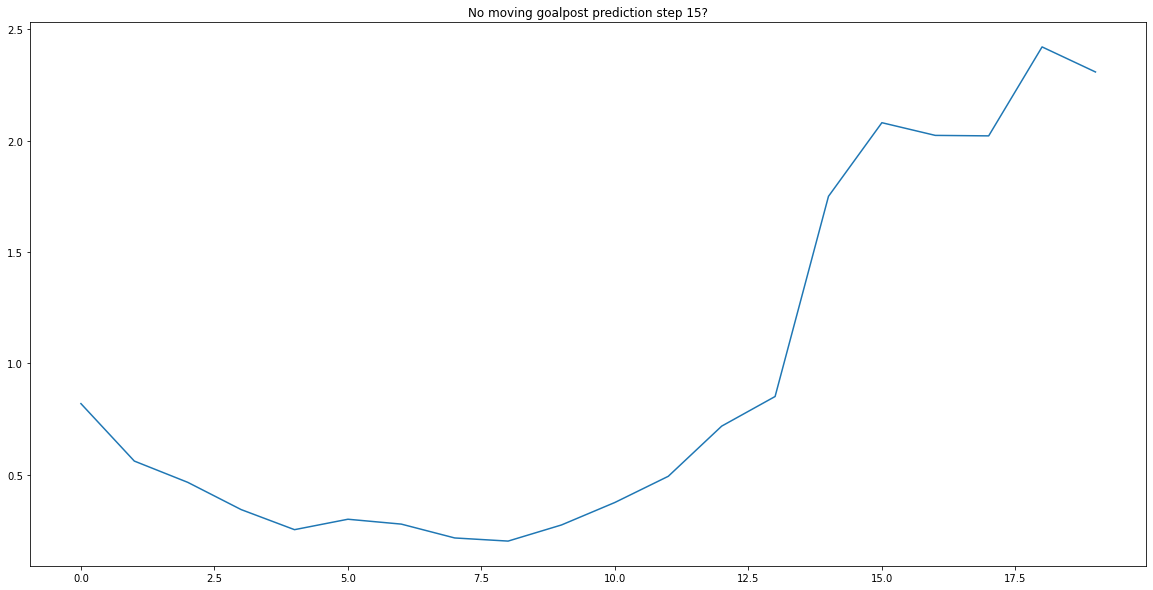

In [15]:
mean_generation_scores_hox = np.nanmean(np.abs(np.array(generation_scores[1:])), axis = 1)
fig = plt.figure(figsize = (20,10))
plt.title("No moving goalpost prediction step 15?")
plt.plot(mean_generation_scores_hox)
fig.savefig("No moving goalpost prediction step 15.jpg")


In [ ]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import logistic_map
rpy.set_seed(9)

size = 100
predict_t_ahead = 2
train_up_to = 100
test_to = train_up_to + 100


weights =  np.random.normal(0,1, size = (size,size))
weights = weights / (weights*size)
print(np.amax(np.linalg.eigvals(weights)))

reservoir = Reservoir(W = weights)
readout = Ridge(ridge = 1e-7)

esn_model = reservoir >> readout

X = logistic_map(2000)
#X  = X[:,np.newaxis]
X = 2 * (X - X.min()) / (X.max() - X.min()) - 1
#X = np.repeat(X[:], 10, axis = 1)

esn_model.fit(X[:train_up_to], X[predict_t_ahead:train_up_to + predict_t_ahead])

#X = np.random.normal(0,1, size = (2000,))
#X  = X[:,np.newaxis]
#X = 2 * (X - X.min()) / (X.max() - X.min()) - 1

#reservoir.reset()
prediction = esn_model.run(X[train_up_to:test_to + predict_t_ahead])


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=affd06f4-455d-4db0-beca-a63ea1debc03' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>